In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import equinox as eqx
import optax
import numpy as np
from pyscf import dft
import pylibxc
import pyscfad.dft as dftad
from jax import custom_jvp

/home/awills/anaconda3/envs/pyscfad/lib/python3.10/site-packages/pyscf/dft/libxc.py:773: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [2]:
#Sampled points can be biased in favor of smaller values of s
# Define the enhancement factor functions (Fx and Fc)
def Fx(rho, grad_rho):
    rho = jnp.maximum(1e-12, rho) #Prevents division by 0
    k_F = (3 * jnp.pi**2 * rho)**(1/3)
    s = grad_rho / (2 * k_F * rho)
    kappa, mu = 0.804, 0.21951

    Fx = 1 + kappa - kappa / (1 + mu * s**2 / kappa) #exchange enhancement factor

    return Fx

def Fc(rho, grad_rho): #Assumes zeta = 0
    rho = jnp.maximum(1e-12, rho) #Prevents division by 0
    pi = jnp.pi
    k_F = (3 * pi**2 * rho)**(1/3)
    s = grad_rho / (2 * k_F * rho)
    k_s = jnp.sqrt((4 * k_F) / pi)
    t = jnp.abs(grad_rho) / (2 * k_s * rho)
    beta = 0.066725
    gamma = (1 - jnp.log(2)) / (pi**2)

    #Calculate e_heg_c (heterogeneous electron gas correlation energy)
    N = rho.size 
    rho_array = np.zeros((6, N))  # Initialize the rho_array with the correct shape. Only the first element (rho) matters, so the rest are populated with 0. 
    rho_array[0, :] = rho  # Populate first array value with rho
    e_heg_c = dft.libxc.eval_xc(',LDA_C_PW', rho_array, spin=0, deriv=1)[0]

    A = (beta / gamma) / (jnp.exp(-e_heg_c / (gamma)) - 1)

    H = gamma * jnp.log(1 + (beta / gamma) * t**2 * ((1 + A * t**2) / (1 + A * t**2 + A**2 * t**4)))

    Fc = 1 + (H / e_heg_c) #correlation enhancement factor

    return Fc

# Including Constraints

There are various constraints which xc-diff and xcquinox are encoded to respect:
- Correct uniform density scaling behavior for $E_x$, which is enforced through dropping local-density inputs to the exchange enhancement factor (here, this means the `FxNet` should only depend on the gradient)
- At $s=0$, the UEG limit should be obtained. If the XC energy density is obtained through multiplying the enhancement factors by the UEG exchange/correlation energy densities, this means that $F_x(s=0)=1$ and $F_c(s=0)=1$.
- [Lieb-Oxford bound for the GGA enhancement factor](https://sci-hub.se/https://doi.org/10.1063/1.4870763) is $F_x^\mathrm{GGA}(s) < 1.804$; for the [MGGA enhancement factor](https://www.pnas.org/doi/epdf/10.1073/pnas.1423145112) is $F_x(s,\alpha) \leq F_x(s,\alpha=0) \leq 1.174$
- Correlation energy is non-positive, so the correlation enhancement factor must be non-negative: $F_c(s,\dots) \geq 0$.
- The exchange energy is negative, so the exchange enhancement factor must be postive: $F_x(s) \geq 0$.

However, these constraints only apply to the actual enhancement factors, **not** a function that predicts a Z-score that will be distribution dependent on whatever training data you train with. As such, I don't train to the Z-scores below as was done above.

The simplest way to enforce both the upper (Lieb-Oxford) and lower (positivity requirements) bounds are to pass the network outputs through a modified sigmoid function. xc-diff and xcquinox do this with the following modified sigmoid -- it enforces the domain to be within $[-1, a-1]$ via $$I_a(x) = \frac{a}{1+(a-1)\exp^{-x}} -1,\ \ I_a(0)=0,$$ and then adds one in the "definition" of the enhancement factor, i.e.: $$F_x(\tilde{x}_2,\tilde{x}_3) = 1 + I_{1.174}[(\tilde{x}_2+\tanh^2\tilde{x}_3)\mathcal{F}(\tilde{x}_2,\tilde{x}_3,\vec{\omega}_x)],$$ where the $(\tilde{x}_2+\tanh^2\tilde{x}_3)$ ensures the UEG limit is recovered for $s=x_2=\tilde{x}_2=0$ at $\alpha=x_3=1\to\tilde{x}_3=0$. $F_c$ is similarly constrained via $I_2(x)$, such that the end result lies in the range $[0, 1]$.

As a start, we'll omit the linear terms and just assume that $$F_x(s) = 1+I_{1.804}[\tanh^2(s)\cdot \mathcal{F}(s,\vec{\omega}_x)]$$ and $$F_c(\rho,s) = 1+I_2[\tanh^2(s)\cdot \mathcal{F}(\rho, s,\vec{\omega}_c)],$$ as $\tanh^2(x)\to0$ as $x\to 0$.

Try to modify the sigmoid wrapping to avoid nans. In running the above interfaces, there were a few `NaN`s appearing in the gradients, potentially due to the [sigmoid wrapping](https://stackoverflow.com/questions/68290850/jax-autograd-of-a-sigmoid-always-returns-nan). As such, below here I re-implement that constraining function to avoid such issues.

In [3]:
#Define the equinox module for the Lieb-Oxford bound enforcement
class LOB2(eqx.Module):
    limit: float

    def __init__(self, limit: float):
        self.limit = limit

    def __call__(self, x):
        #this formulation is so that the constraints can be enforced while avoiding potential gradient issues with the sigmoid
        return self.limit * jax.nn.sigmoid(x-jnp.log(self.limit - 1))-1
        
# Define the neural network module for Fx
class FxNet3(eqx.Module):
    depth: int
    nodes: int
    seed: int
    lob_lim: float
    net: eqx.nn.MLP
    lobf: eqx.Module

    def __init__(self, depth: int, nodes: int, seed: int, lob_lim=1.804):
        self.depth = depth
        self.nodes = nodes
        self.seed = seed
        self.lob_lim = lob_lim
        #to constrain this, we require only gradient inputs
        self.net = eqx.nn.MLP(in_size = 1, # Input is ONLY grad_rho
                              out_size = 1, # Output is Fx
                              depth = self.depth,
                              width_size = self.nodes,
                              activation = jax.nn.gelu,
                              key = jax.random.PRNGKey(self.seed))
        self.lobf = LOB2(limit=lob_lim)

    

    def __call__(self, inputs):
        #here, assume the inputs is [rho, grad] and select the appropriate input
        #takes forever if inputs[1] tanh input has extended shape , i.e. (1,1) as opposed to scalar shape (1,)
        return 1+self.lobf((jnp.tanh(inputs[1])**2)*self.net(inputs[1, jnp.newaxis]).squeeze())


# Define the neural network module for Fc
class FcNet3(eqx.Module):
    depth: int
    nodes: int
    seed: int
    lob_lim: float
    net: eqx.nn.MLP
    lobf: eqx.Module


    def __init__(self, depth: int, nodes: int, seed: int, lob_lim=2.0):
        self.depth = depth
        self.nodes = nodes
        self.seed = seed
        self.lob_lim = lob_lim
        self.net = eqx.nn.MLP(in_size = 2, # Input is rho, grad_rho
                              out_size = 1, # Output is Fx
                              depth = self.depth,
                              width_size = self.nodes,
                              activation = jax.nn.gelu,
                              key = jax.random.PRNGKey(self.seed))
        self.lobf = LOB2(limit=lob_lim)

    def __call__(self, inputs):
        return 1+self.lobf((jnp.tanh(inputs[1])**2)*self.net(inputs).squeeze())


In [4]:
NPTS = 30000  # Note: Number of grid points [i.e. (x,y) pairs] is actually sqrt(NPTS).

# Generate test points
NUM_RHO = 1000  # Number of different rho values to test
NUM_S = 1000  # Number of s values for each rho

START_S, STOP_S = 0.01, 5  # Adjust these values as needed
START_RHO, STOP_RHO = 0.01, 5  # Range of rho values to test

test_s = jnp.linspace(START_S, STOP_S, num=NPTS)
test_rho = jnp.linspace(START_RHO, STOP_RHO, num=NPTS)

# Generate training data
# Create more points for small values of s
s_values_low = jnp.linspace(START_S, 0.5, num=int(0.7 * jnp.sqrt(NPTS)))
s_values_high = jnp.linspace(0.5, STOP_S, num=int(0.3 * jnp.sqrt(NPTS)))
s_values = jnp.concatenate([s_values_low, s_values_high])

rho_values = jnp.logspace(jnp.log10(START_RHO), jnp.log10(STOP_RHO), num=int(jnp.sqrt(NPTS)))
#s_values = jnp.linspace(START_S, STOP_S, num=int(jnp.sqrt(NPTS))) #Use this for unbiased sampling

rho_mesh, s_mesh = jnp.meshgrid(rho_values, s_values)
rho_flat = rho_mesh.flatten()
s_flat = s_mesh.flatten()

# Calculate grad_rho
k_F = (3 * jnp.pi**2 * rho_flat)**(1/3)
grad_rho_flat = 2 * s_flat * k_F * rho_flat

# Create input array
inputs = jnp.stack([rho_flat, grad_rho_flat], axis=1)
sinputs = jnp.stack([rho_flat, s_flat], axis=1)

# Calculate true Fx and Fc values
true_fx = Fx(rho_flat, grad_rho_flat)
true_fc = Fc(rho_flat, grad_rho_flat)

# Normalize inputs and outputs
inputs_mean = inputs.mean(axis=0)
inputs_std = inputs.std(axis=0)
inputs_normalized = (inputs - inputs_mean) / (inputs_std + 1e-8)

true_fx_mean = true_fx.mean()
true_fx_std = true_fx.std()
true_fx_normalized = (true_fx - true_fx_mean) / (true_fx_std + 1e-8)

true_fc_mean = true_fc.mean()
true_fc_std = true_fc.std()
true_fc_normalized = (true_fc - true_fc_mean) / (true_fc_std + 1e-8)

# Define the training loop function
def loop(model, model_name, inputs, ref, optimizer, epochs=1000000, printevery=2500): #model_name is just for printing purposes
    @eqx.filter_value_and_grad
    def compute_loss(model, inputs, ref):
        pred = jax.vmap(model)(inputs)
        loss = jnp.mean(jnp.abs(pred - ref))
        return loss

    @eqx.filter_jit
    def make_step(model, inputs, ref, opt_state):
        loss, grad = compute_loss(model, inputs, ref)
        updates, opt_state = optimizer.update(grad, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state
    print(f"Starting training for model: {model_name}")
    
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))
    losses = []

    for step in range(epochs):
        loss, model, opt_state = make_step(model, inputs, ref, opt_state)
        lossi = loss.item()
        losses.append(lossi)
        if step % printevery == 0:
            print(f'Epoch {step}: Loss = {lossi}')

    return model, losses

# Create optimizers
optimizer_fx = optax.chain(
    optax.adam(learning_rate=1e-3)
)
optimizer_fc = optax.chain(
    optax.adam(learning_rate=1e-3)
)

model_fx3 = FxNet3(depth=3, nodes=16, seed=42)
model_fc3 = FcNet3(depth=3, nodes=16, seed=42)

# Train the Fx model -- Fx(s)
model_fx3, losses_fx = loop(model_fx3, 'Fx', s_flat[:, jnp.newaxis], true_fx, optimizer_fx, epochs=5000, printevery=100) #Can adjust number of epochs 

# Train the Fc model -- Fc(rho, s)
model_fc3, losses_fc = loop(model_fc3, 'Fc', sinputs, true_fc, optimizer_fc, epochs=5000, printevery=100) #Can adjust number of epochs 


Starting training for model: Fx
Epoch 0: Loss = 0.1720148024971639
Epoch 100: Loss = 0.008971895299887012
Epoch 200: Loss = 0.00041547394021028026
Epoch 300: Loss = 0.000265919547447219
Epoch 400: Loss = 0.00021032480170918327
Epoch 500: Loss = 0.0004211246666723421
Epoch 600: Loss = 0.00015184608677665183
Epoch 700: Loss = 0.0001265169241386113
Epoch 800: Loss = 0.00029470721752729165
Epoch 900: Loss = 0.00021367057794980523
Epoch 1000: Loss = 0.0003806253110167202
Epoch 1100: Loss = 0.00031396786172692046
Epoch 1200: Loss = 0.0001735424005038994
Epoch 1300: Loss = 8.236852724039564e-05
Epoch 1400: Loss = 0.00017757969482683886
Epoch 1500: Loss = 0.00016798057982561146
Epoch 1600: Loss = 0.0004011100645595441
Epoch 1700: Loss = 0.0004653558280359184
Epoch 1800: Loss = 0.00025957121309487535
Epoch 1900: Loss = 0.0002802766636075748
Epoch 2000: Loss = 0.0002796524566991856
Epoch 2100: Loss = 0.00010332342980436528
Epoch 2200: Loss = 0.0003306536033920642
Epoch 2300: Loss = 0.00058857119

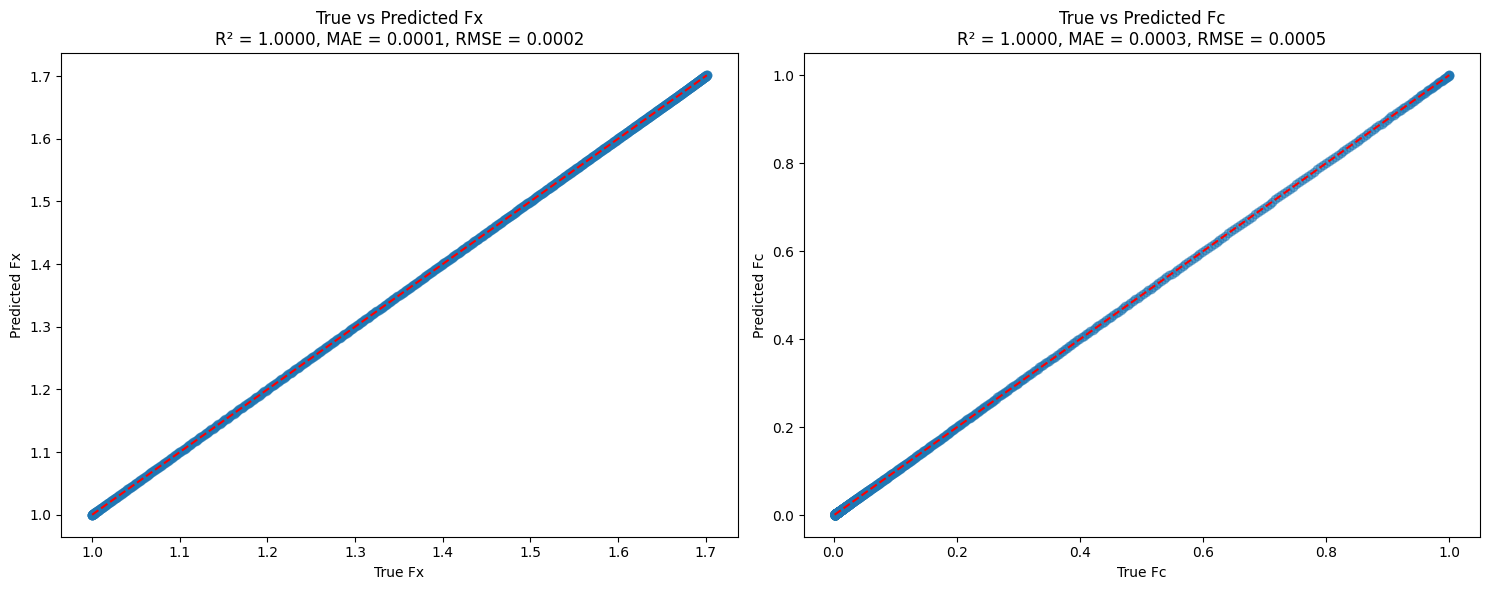

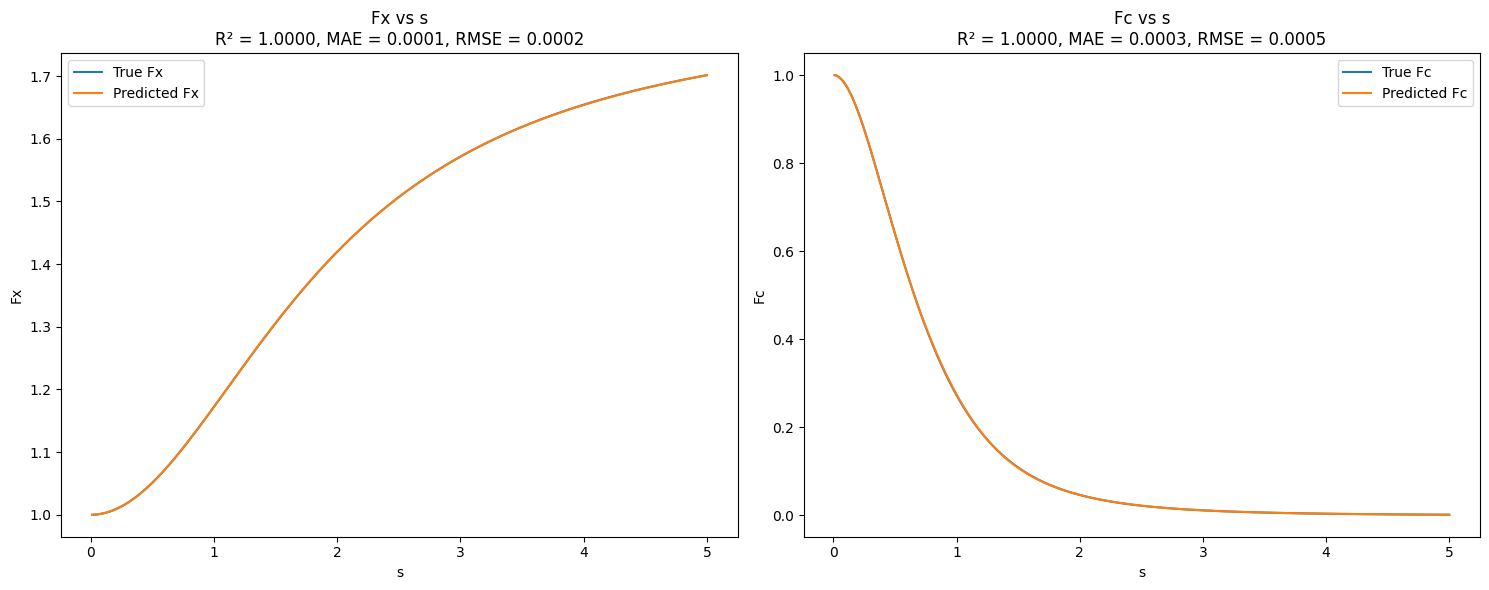

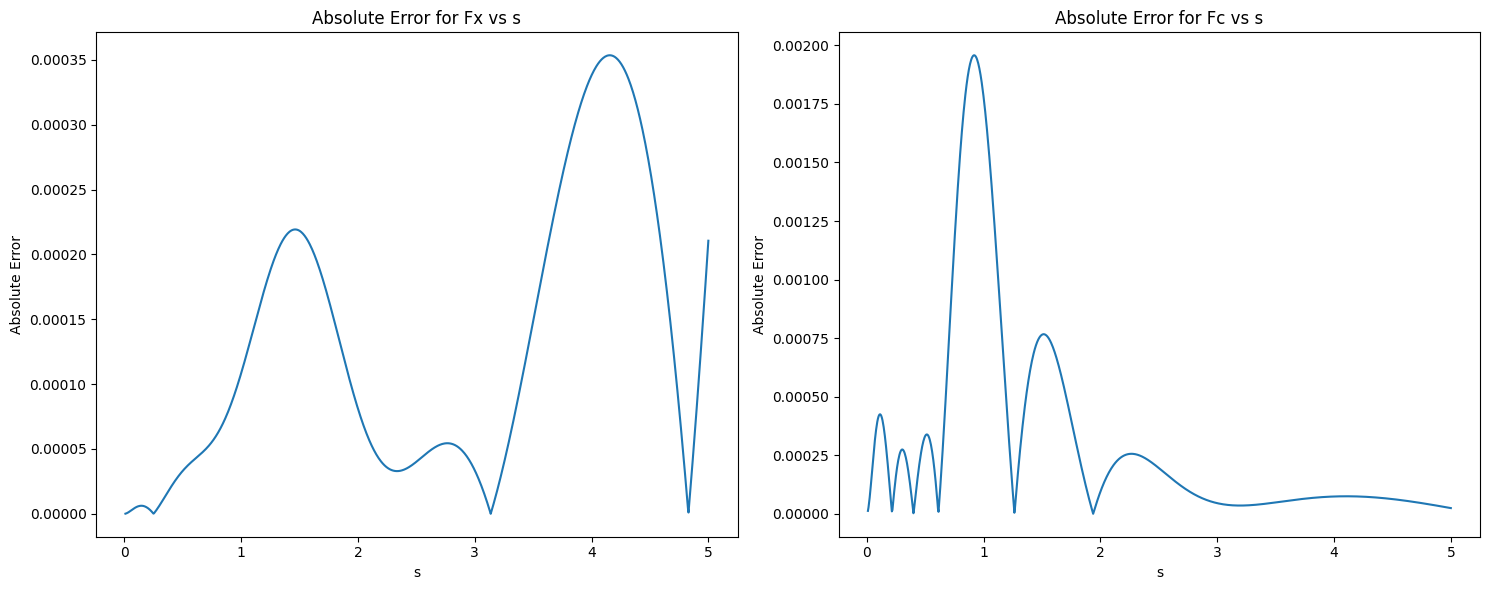

Fx Statistics:
R-squared: 0.999999
Mean Absolute Error: 0.000128
Root Mean Squared Error: 0.000167
Maximum Absolute Error: 0.000354

Fc Statistics:
R-squared: 0.999996
Mean Absolute Error: 0.000297
Root Mean Squared Error: 0.000530
Maximum Absolute Error: 0.001958


In [5]:
# Generate test points
test_s = jnp.linspace(START_S, STOP_S, num=1000)
test_rho = jnp.full_like(test_s, 1.0)  # We'll use a constant rho for simplicity

# Calculate grad_rho for the test points
k_F_test = (3 * jnp.pi**2 * test_rho)**(1/3)
grad_rho_test = 2 * test_s * k_F_test * test_rho

# Prepare inputs for the neural networks
test_inputs = jnp.stack([test_rho, grad_rho_test], axis=1)
test_sinputs = jnp.stack([test_rho, test_s], axis=1)
test_inputs_normalized = (test_inputs - inputs_mean) / (inputs_std + 1e-8)

# Calculate true PBE enhancement factors
true_fx_test = Fx(test_rho, grad_rho_test)
true_fc_test = Fc(test_rho, grad_rho_test)

# Predict using neural networks
#NOTE -- the inputs here ARE the s values, not the grad_rho values
pred_fx = jax.vmap(model_fx3)(test_s[:, jnp.newaxis]).squeeze()
# pred_fx = jax.vmap(model_fx2)(grad_rho_test[:, jnp.newaxis]).squeeze()

#The inputs here 
pred_fc = jax.vmap(model_fc3)(test_sinputs).squeeze()

# Function to calculate statistics
def calculate_stats(true, pred):
    # R-squared
    ss_res = np.sum((true - pred) ** 2)
    ss_tot = np.sum((true - np.mean(true)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    # Mean Absolute Error
    mae = np.mean(np.abs(true - pred))
    
    # Root Mean Squared Error
    rmse = np.sqrt(np.mean((true - pred) ** 2))
    
    return r2, mae, rmse

# Calculate statistics
r2_fx, mae_fx, rmse_fx = calculate_stats(true_fx_test, pred_fx)
r2_fc, mae_fc, rmse_fc = calculate_stats(true_fc_test, pred_fc)

# 1. Correlation plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter(true_fx_test, pred_fx, alpha=0.5)
ax1.plot([true_fx_test.min(), true_fx_test.max()], [true_fx_test.min(), true_fx_test.max()], 'r--')
ax1.set_xlabel('True Fx')
ax1.set_ylabel('Predicted Fx')
ax1.set_title(f'True vs Predicted Fx\nR² = {r2_fx:.4f}, MAE = {mae_fx:.4f}, RMSE = {rmse_fx:.4f}')

ax2.scatter(true_fc_test, pred_fc, alpha=0.5)
ax2.plot([true_fc_test.min(), true_fc_test.max()], [true_fc_test.min(), true_fc_test.max()], 'r--')
ax2.set_xlabel('True Fc')
ax2.set_ylabel('Predicted Fc')
ax2.set_title(f'True vs Predicted Fc\nR² = {r2_fc:.4f}, MAE = {mae_fc:.4f}, RMSE = {rmse_fc:.4f}')

plt.tight_layout()
plt.show()

# 2. True PBE factors vs. s
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(test_s, true_fx_test, label='True Fx')
ax1.plot(test_s, pred_fx, label='Predicted Fx')
ax1.set_xlabel('s')
ax1.set_ylabel('Fx')
ax1.set_title(f'Fx vs s\nR² = {r2_fx:.4f}, MAE = {mae_fx:.4f}, RMSE = {rmse_fx:.4f}')
ax1.legend()

ax2.plot(test_s, true_fc_test, label='True Fc')
ax2.plot(test_s, pred_fc, label='Predicted Fc')
ax2.set_xlabel('s')
ax2.set_ylabel('Fc')
ax2.set_title(f'Fc vs s\nR² = {r2_fc:.4f}, MAE = {mae_fc:.4f}, RMSE = {rmse_fc:.4f}')
ax2.legend()

plt.tight_layout()
plt.show()

# 3. Error plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(test_s, np.abs(true_fx_test - pred_fx))
ax1.set_xlabel('s')
ax1.set_ylabel('Absolute Error')
ax1.set_title('Absolute Error for Fx vs s')

ax2.plot(test_s, np.abs(true_fc_test - pred_fc))
ax2.set_xlabel('s')
ax2.set_ylabel('Absolute Error')
ax2.set_title('Absolute Error for Fc vs s')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Fx Statistics:")
print(f"R-squared: {r2_fx:.6f}")
print(f"Mean Absolute Error: {mae_fx:.6f}")
print(f"Root Mean Squared Error: {rmse_fx:.6f}")
print(f"Maximum Absolute Error: {np.max(np.abs(true_fx_test - pred_fx)):.6f}")

print(f"\nFc Statistics:")
print(f"R-squared: {r2_fc:.6f}")
print(f"Mean Absolute Error: {mae_fc:.6f}")
print(f"Root Mean Squared Error: {rmse_fc:.6f}")
print(f"Maximum Absolute Error: {np.max(np.abs(true_fc_test - pred_fc)):.6f}")

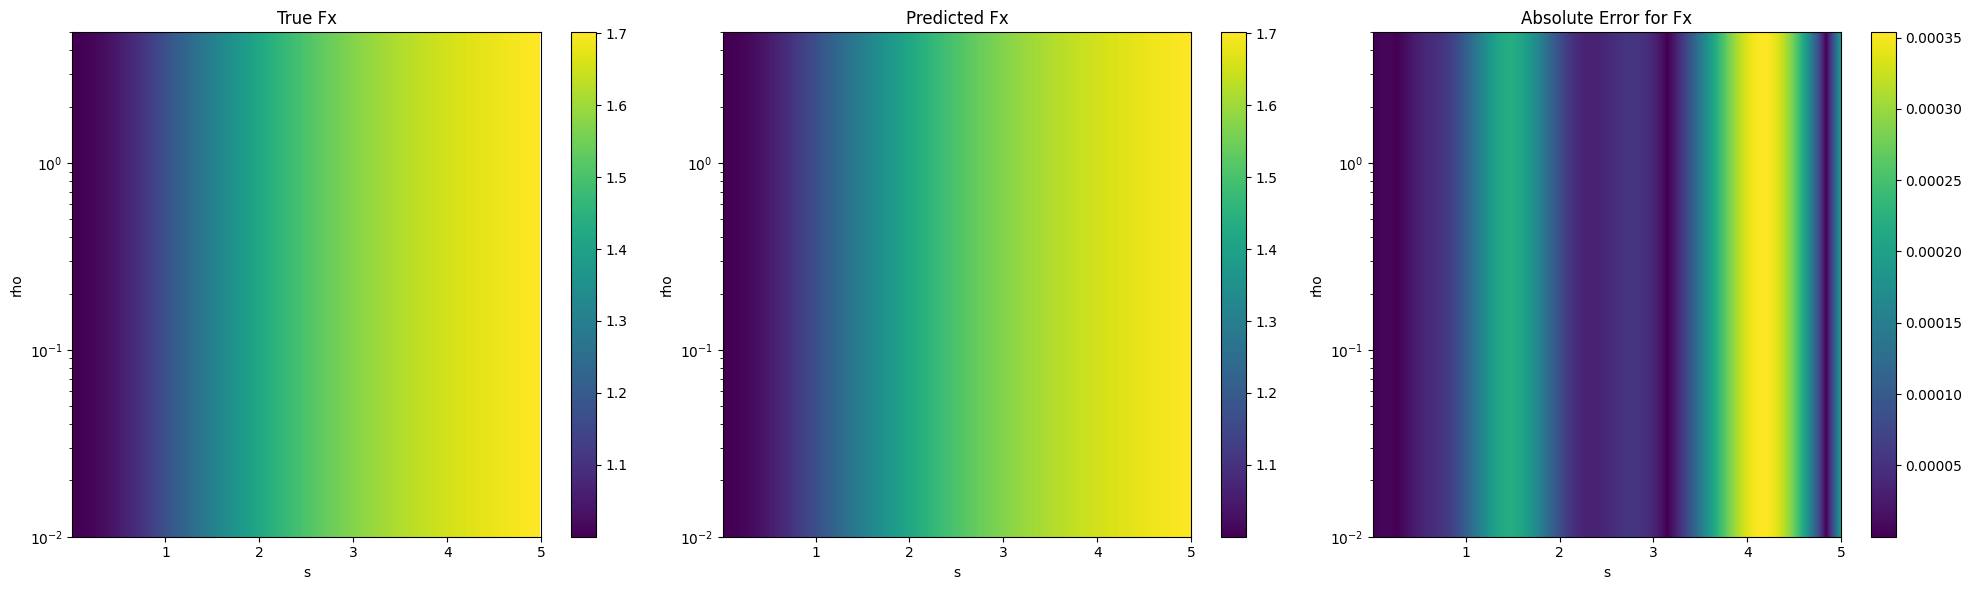

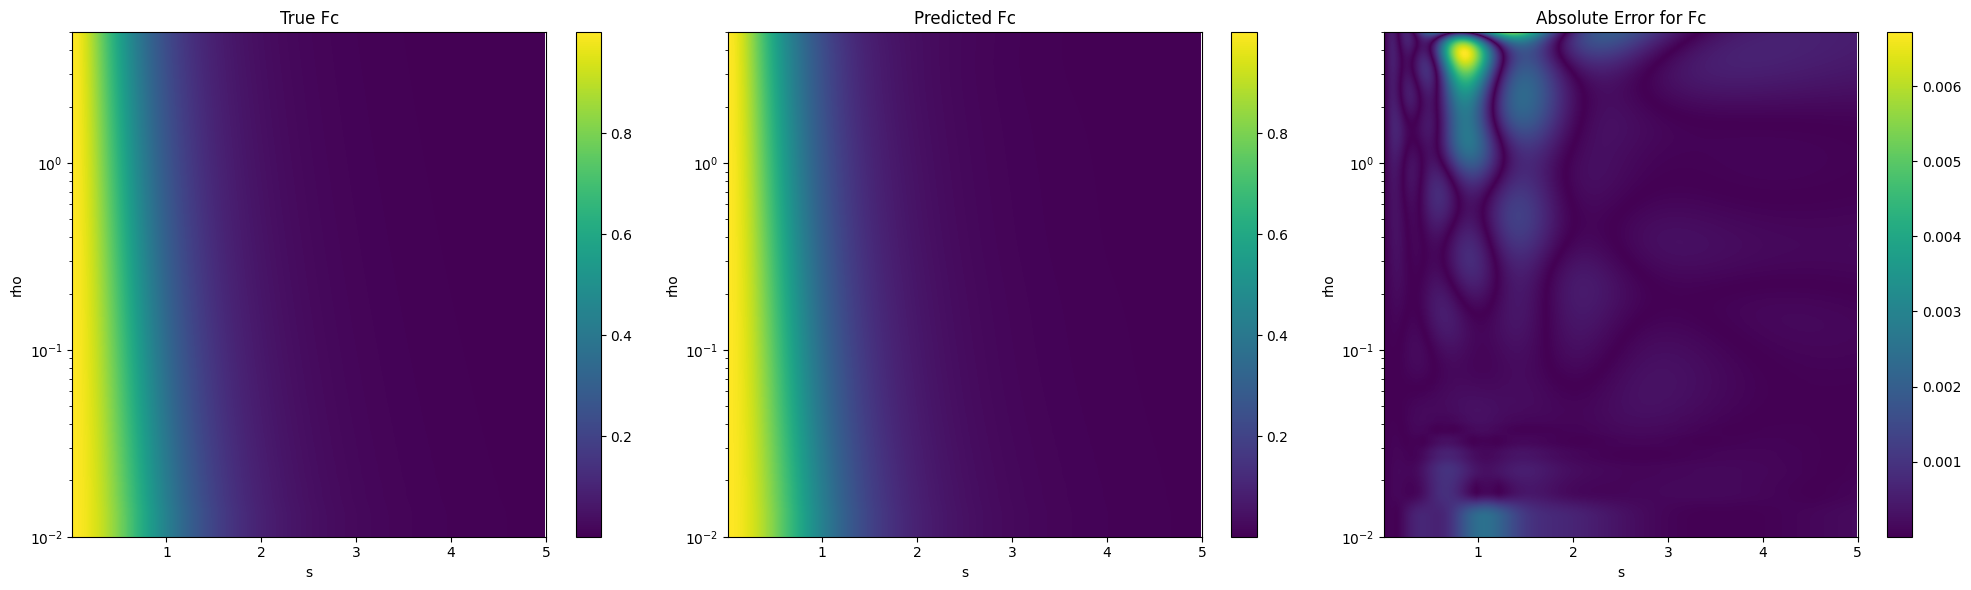

Fx Statistics:
R-squared: 0.999999
Mean Absolute Error: 0.000128
Root Mean Squared Error: 0.000167
Maximum Absolute Error: 0.000354

Fc Statistics:
R-squared: 0.999978
Mean Absolute Error: 0.000703
Root Mean Squared Error: 0.001239
Maximum Absolute Error: 0.006716


In [6]:
# Generate test points
NUM_RHO = 1000  # Number of different rho values to test
NUM_S = 1000  # Number of s values for each rho

START_S, STOP_S = 0.01, 5  # Adjust these values as needed
START_RHO, STOP_RHO = 0.01, 5  # Range of rho values to test

test_s = jnp.linspace(START_S, STOP_S, num=NUM_S)
test_rho = jnp.linspace(START_RHO, STOP_RHO, num=NUM_RHO)

# Create meshgrid for s and rho
s_mesh, rho_mesh = jnp.meshgrid(test_s, test_rho)

# Calculate grad_rho for the test points
k_F_test = (3 * jnp.pi**2 * rho_mesh)**(1/3)
grad_rho_test = 2 * s_mesh * k_F_test * rho_mesh

# Prepare inputs for the neural networks
test_inputs = jnp.stack([rho_mesh.flatten(), grad_rho_test.flatten()], axis=1)
test_sinputs = jnp.stack([rho_mesh.flatten(), s_mesh.flatten()], axis=1)
test_inputs_normalized = (test_inputs - inputs_mean) / (inputs_std + 1e-8)

# Calculate true PBE enhancement factors
true_fx_test = Fx(rho_mesh.flatten(), grad_rho_test.flatten())
true_fc_test = Fc(rho_mesh.flatten(), grad_rho_test.flatten())

# Predict using neural networks
# pred_fx_normalized = jax.vmap(model_fx)(test_inputs_normalized).squeeze()
# pred_fx = pred_fx_normalized * true_fx_std + true_fx_mean
pred_fx = jax.vmap(model_fx3)(s_mesh.flatten()[:, jnp.newaxis])

# pred_fc_normalized = jax.vmap(model_fc)(test_inputs_normalized).squeeze()
# pred_fc = pred_fc_normalized * true_fc_std + true_fc_mean
pred_fc = jax.vmap(model_fc3)(test_sinputs)

# Reshape results
true_fx_test = true_fx_test.reshape(NUM_RHO, NUM_S)
true_fc_test = true_fc_test.reshape(NUM_RHO, NUM_S)
pred_fx = pred_fx.reshape(NUM_RHO, NUM_S)
pred_fc = pred_fc.reshape(NUM_RHO, NUM_S)

# Function to calculate statistics
def calculate_stats(true, pred):
    true_flat = true.flatten()
    pred_flat = pred.flatten()
    
    # R-squared
    ss_res = np.sum((true_flat - pred_flat) ** 2)
    ss_tot = np.sum((true_flat - np.mean(true_flat)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    
    # Mean Absolute Error
    mae = np.mean(np.abs(true_flat - pred_flat))
    
    # Root Mean Squared Error
    rmse = np.sqrt(np.mean((true_flat - pred_flat) ** 2))
    
    # Maximum Absolute Error
    max_error = np.max(np.abs(true_flat - pred_flat))
    
    return r2, mae, rmse, max_error

# Calculate statistics
r2_fx, mae_fx, rmse_fx, max_error_fx = calculate_stats(true_fx_test, pred_fx)
r2_fc, mae_fc, rmse_fc, max_error_fc = calculate_stats(true_fc_test, pred_fc)

# Plotting
def plot_heatmap(true, pred, title, rho_values, s_values):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    im1 = ax1.imshow(true, aspect='auto', origin='lower', extent=[s_values[0], s_values[-1], rho_values[0], rho_values[-1]])
    ax1.set_title(f'True {title}')
    ax1.set_xlabel('s')
    ax1.set_ylabel('rho')
    ax1.set_yscale('log')
    fig.colorbar(im1, ax=ax1)
    
    im2 = ax2.imshow(pred, aspect='auto', origin='lower', extent=[s_values[0], s_values[-1], rho_values[0], rho_values[-1]])
    ax2.set_title(f'Predicted {title}')
    ax2.set_xlabel('s')
    ax2.set_ylabel('rho')
    ax2.set_yscale('log')
    fig.colorbar(im2, ax=ax2)
    
    error = np.abs(true - pred)
    im3 = ax3.imshow(error, aspect='auto', origin='lower', extent=[s_values[0], s_values[-1], rho_values[0], rho_values[-1]])
    ax3.set_title(f'Absolute Error for {title}')
    ax3.set_xlabel('s')
    ax3.set_ylabel('rho')
    ax3.set_yscale('log')
    fig.colorbar(im3, ax=ax3)
    
    plt.tight_layout()
    plt.show()

# Plot heatmaps
plot_heatmap(true_fx_test, pred_fx, 'Fx', test_rho, test_s)
plot_heatmap(true_fc_test, pred_fc, 'Fc', test_rho, test_s)

# Print statistics
print(f"Fx Statistics:")
print(f"R-squared: {r2_fx:.6f}")
print(f"Mean Absolute Error: {mae_fx:.6f}")
print(f"Root Mean Squared Error: {rmse_fx:.6f}")
print(f"Maximum Absolute Error: {max_error_fx:.6f}")

print(f"\nFc Statistics:")
print(f"R-squared: {r2_fc:.6f}")
print(f"Mean Absolute Error: {mae_fc:.6f}")
print(f"Root Mean Squared Error: {rmse_fc:.6f}")
print(f"Maximum Absolute Error: {max_error_fc:.6f}")

# An Interface to PySCF

There is a brief description of how to customize an XC functional in PySCF [here](https://pyscf.org/user/dft.html). The github repo has further examples [here](https://github.com/pyscf/pyscf/blob/master/examples/dft/24-custom_xc_functional.py) and [here](https://github.com/pyscf/pyscf/blob/master/examples/dft/24-define_xc_functional.py). The prior focuses on custom combinations of existing functionals, while the latter focuses on truly custom functionals.

We must first, however, generate the density expected by PySCF.
- Get the atomic orbitals and coordinates for a given calculation
- Use those in generating the density values
- Convert to the expected network inputs

The first `eval_xc` function below will be ignoring the `vrho` and `vgamma` values used in the SCF cycle for a GGA, to illustrate the error in `Exc` generated from not utilizing these values.

In [44]:
import pyscf
from pyscf import dft, scf, gto
print(pyscf.__version__)

2.3.0


In [45]:
mol = gto.M(
    atom = '''
    O  0.   0.       0.
    H  0.   -0.757   0.587
    H  0.   0.757    0.587 ''',
    basis = 'ccpvdz')
mol.verbose = 0
mf = dft.RKS(mol)
mf.xc = 'pbe'
mf.kernel()

-76.33345765899357

In [46]:
Epbe = mf.e_tot
mf.scf_summary

{'e1': -123.16722829254861,
 'coul': 46.92499882266204,
 'exc': -9.279486606853109,
 'nuc': 9.188258417746113}

In [47]:
#deriv = 1 for GGA rho input
ao = dft.numint.eval_ao(mol, mf.grids.coords, deriv=1)
dm = mf.make_rdm1()
rho = dft.numint.eval_rho(mol, ao, dm, xctype='GGA')

In [48]:
h2o_heg_x = dft.libxc.eval_xc(1, rho, spin=0, deriv=0)[0]
h2o_heg_c = dft.libxc.eval_xc(12, rho, spin=0, deriv=0)[0]

What derivatives does LibXC calculate for PBE?

In [49]:
heg_rho_array = np.zeros((6, len(rho_flat)))  # Initialize the rho_array with the correct shape. Only the first element (rho) matters, so the rest are populated with 0. 
heg_rho_array[0, :] = rho_flat  # Populate first array value with rho
e_heg_c = dft.libxc.eval_xc(',LDA_C_PW', heg_rho_array, spin=0, deriv=1)
e_heg_x = dft.libxc.eval_xc('LDA_X,', heg_rho_array, spin=0, deriv=1)
print(len(e_heg_c), len(e_heg_x))
print(e_heg_c, e_heg_x)
print([len(i) for i in e_heg_c if  type(i) != type(None)])
print([len(i) for i in e_heg_x if type(i) != type(None)])

4 4
(array([-2.53203315e-04, -8.79904566e-05, -1.67454465e-04, ...,
       -1.22995127e-01, -1.22995127e-01, -1.22995127e-01]), [array([-3.34222898e-04, -1.16627237e-04, -2.21453193e-04, ...,
       -1.32718315e-01, -1.32718315e-01, -1.32718315e-01])], None, None) (array([-2.90427953e-04, -9.75533105e-05, -1.89112277e-04, ...,
       -4.92694708e+00, -4.92694708e+00, -4.92694708e+00]), [array([-3.87237270e-04, -1.30071081e-04, -2.52149702e-04, ...,
       -6.56926277e+00, -6.56926277e+00, -6.56926277e+00])], None, None)
[9088, 1]
[9088, 1]


So the second-order functional derivatives are not being calculated, which is good for us in terms of computational efficiency. We just need to generate the energy densities and the potentials associated with them. **Notably, the returned `vxc` is of length one, indicating only `vrho` is returned.**

# Grid-point gradients
As libxc expects the derivatives w.r.t. the energy *density*, not the integrated exchange-correlation energy, we must modify what `eval_xc` does.

In [50]:
func_lda_x = pylibxc.LibXCFunctional("lda_x", "unpolarized")
func_lda_c_pw = pylibxc.LibXCFunctional("lda_c_pw", "unpolarized")

In [51]:
inp = {}
inp['rho'] = rho[0]
inp['sigma'] = np.sqrt(rho[1]**2+rho[2]**2+rho[3]**2)

In [52]:
ret_lda_x = func_lda_x.compute(inp)
ret_lda_c = func_lda_c_pw.compute(inp)

In [53]:
def pw91_correlation_energy_density(rho):
    """
    Calculate the correlation energy density according to the PW91 functional.

    Parameters:
    - rho: electron density (numpy array or scalar)
    - grad_rho: gradient of the electron density (numpy array or scalar)

    Returns:
    - correlation energy density (numpy array or scalar)
    """
    A = 0.0311
    B = 0.116
    C = 0.145
    
    # Compute the correlation energy density
    rho_1_3 = np.cbrt(rho)  # rho^(1/3)
    term1 = 1 / np.sqrt(1 + C / rho_1_3)
    epsilon_c = -A / rho * (1 + B * (term1 - 1))
    
    return epsilon_c    
def lda_c_pw(rho):
    params_a_pp     = [1,  1,  1]
    params_a_a      = [0.031091, 0.015545, 0.016887]
    params_a_alpha1 = [0.21370,  0.20548,  0.11125]
    params_a_beta1  = [7.5957, 14.1189, 10.357]
    params_a_beta2  = [3.5876, 6.1977, 3.6231]
    params_a_beta3  = [1.6382, 3.3662,  0.88026]
    params_a_beta4  = [0.49294, 0.62517, 0.49671]
    params_a_fz20   = 1.709921

    zeta = (rho - rho)/(rho + rho + 1e-8)
    rs = (4*np.pi/3*(rho + 1e-8))**(-1/3)

    def g_aux(k, rs):
        return params_a_beta1[k]*jnp.sqrt(rs) + params_a_beta2[k]*rs\
      + params_a_beta3[k]*rs**1.5 + params_a_beta4[k]*rs**(params_a_pp[k] + 1)

    def g(k, rs):
        return -2*params_a_a[k]*(1 + params_a_alpha1[k]*rs)\
      * jnp.log(1 +  1/(2*params_a_a[k]*g_aux(k, rs)))

    def f_zeta(zeta):
        return ((1+zeta)**(4/3) + (1-zeta)**(4/3) - 2)/(2**(4/3)-2)

    def f_pw(rs, zeta):
        return g(0, rs) + zeta**4*f_zeta(zeta)*(g(1, rs) - g(0, rs) + g(2, rs)/params_a_fz20)\
      - f_zeta(zeta)*g(2, rs)/params_a_fz20

    return f_pw(rs, zeta)

def lda_x(rho):
    return -3/4*(3/jnp.pi)**(1/3)*rho**(1/3)


In [54]:
h2o_lda_x = lda_x(rho[0])
h2o_lda_c = lda_c_pw(rho[0])

In [55]:
print('CODED Exchange Energy Density vs. PySCF.DFT.LIBXC: MAE = ', jnp.mean(abs(h2o_heg_x - h2o_lda_x)))
print('CODED Correlation Energy Density vs. PySCF.DFT.LIBXC: MAE = ', jnp.mean(abs(h2o_heg_c - h2o_lda_c)))

CODED Exchange Energy Density vs. PySCF.DFT.LIBXC: MAE =  5.0673514076701e-17
CODED Correlation Energy Density vs. PySCF.DFT.LIBXC: MAE =  6.268388461821058e-05


In [56]:
for k, v in ret_lda_x.items():
    print(k, v)
for k, v in ret_lda_c.items():
    print(k, v)

zk [[-1.42085851e-04 -7.71844046e-05 -1.40585423e-04 ... -4.92694708e+00
  -4.92694708e+00 -4.92694708e+00]]
vrho [[-1.89447801e-04 -1.02912539e-04 -1.87447231e-04 ... -6.56926277e+00
  -6.56926277e+00 -6.56926277e+00]]
zk [[-1.26913516e-04 -6.99834446e-05 -1.25611055e-04 ... -1.22995127e-01
  -1.22995127e-01 -1.22995127e-01]]
vrho [[-1.68017264e-04 -9.28193670e-05 -1.66299076e-04 ... -1.32718315e-01
  -1.32718315e-01 -1.32718315e-01]]


In [57]:
print('CODED Exchange Energy Density vs. PYLIBXC: MAE = ', jnp.mean(abs(ret_lda_x['zk'] - h2o_lda_x)))
print('CODED Correlation Energy Density vs. PYLIBXC: MAE = ', jnp.mean(abs(ret_lda_c['zk'] - h2o_lda_c)))

CODED Exchange Energy Density vs. PYLIBXC: MAE =  1.4114690049703597e-16
CODED Correlation Energy Density vs. PYLIBXC: MAE =  6.268388461820553e-05


In [58]:
func_lda_c_pw.compute({'rho': 1.0}, do_vxc = False)

[array([[-0.07120031]])]

In [59]:
mol = gto.M(
    atom = '''
    O  0.   0.       0.
    H  0.   -0.757   0.587
    H  0.   0.757    0.587 ''',
    basis = 'ccpvdz')
mol.verbose = 0
pmf = dft.RKS(mol)
pmf.grids.level = 1
pmf.xc = 'pbe'
pmf.kernel()

-76.33342437818283

In [60]:
print(pmf.scf_summary)
#deriv = 1 for GGA rho input
ao = dft.numint.eval_ao(mol, pmf.grids.coords, deriv=1)
dm = mf.make_rdm1()
rho = dft.numint.eval_rho(mol, ao, dm, xctype='GGA')
print(rho.shape)

{'e1': -123.1672624930811, 'coul': 46.92503796722725, 'exc': -9.279458270075093, 'nuc': 9.188258417746113}
(4, 9088)


In [61]:
func_lda_x = pylibxc.LibXCFunctional("lda_x", "unpolarized")
func_lda_c_pw = pylibxc.LibXCFunctional("lda_c_pw", "unpolarized")
h2o_lda_x = func_lda_x.compute({'rho':rho[0]})
h2o_lda_c = func_lda_c_pw.compute({'rho':rho[0]})
rho_flat = rho[0].flatten()
heg_rho_array = np.zeros((6, len(rho_flat)))  # Initialize the rho_array with the correct shape. Only the first element (rho) matters, so the rest are populated with 0. 
heg_rho_array[0, :] = rho_flat  # Populate first array value with rho
e_heg_c = dft.libxc.eval_xc(',LDA_C_PW', heg_rho_array, spin=0, deriv=1)
e_heg_x = dft.libxc.eval_xc('LDA_X,', heg_rho_array, spin=0, deriv=1)
print(len(e_heg_c), len(e_heg_x))
print(e_heg_c, e_heg_x)
print([len(i) for i in e_heg_c if  type(i) != type(None)])
print([len(i) for i in e_heg_x if type(i) != type(None)])

4 4
(array([-2.53203315e-04, -8.79904566e-05, -1.67454465e-04, ...,
       -1.22995127e-01, -1.22995127e-01, -1.22995127e-01]), [array([-3.34222898e-04, -1.16627237e-04, -2.21453193e-04, ...,
       -1.32718315e-01, -1.32718315e-01, -1.32718315e-01])], None, None) (array([-2.90427953e-04, -9.75533105e-05, -1.89112277e-04, ...,
       -4.92694708e+00, -4.92694708e+00, -4.92694708e+00]), [array([-3.87237270e-04, -1.30071081e-04, -2.52149702e-04, ...,
       -6.56926277e+00, -6.56926277e+00, -6.56926277e+00])], None, None)
[9088, 1]
[9088, 1]


In [286]:
#store as global values for use in function below
GRIDC = pmf.grids.coords
GRIDW = pmf.grids.weights

def get_heg_ec(rho):
    inp = {'rho':rho}
    print(f'get_heg_ec rho  = {rho}')
    shape = jax.core.ShapedArray( rho.shape, rho[0].dtype)
    compute_func = lambda x: func_lda_c_pw.compute(x, do_vxc=False)
    calc = jax.pure_callback(compute_func, shape, inp, vectorized=True)[0]
    return calc
def get_heg_ec_vrho(rho):
    shape = jax.core.ShapedArray( rho.shape, rho[0].dtype)
    compute_func = lambda x: func_lda_c_pw.compute(x, do_exc=False)
    calc = jax.pure_callback(compute_func, shape, inp, vectorized=True)[0]
    return vrho
def get_heg_ec2(rho):
    calc = lda_c_pw(rho)
    return calc
    
def get_heg_ex(rho):
    return lda_x(rho)

get_heg_ec = custom_jvp(get_heg_ec)
get_heg_ex = custom_jvp(get_heg_ex)

@get_heg_ec.defjvp
def _get_heg_ec_jvp(primals, tangents):
    rho = primals
    rho_dot = tangents
    # calc_zk = get_heg_ec(rho, sigma)
    return get_heg_ec(rho), get_heg_ec_vrho(rho)

@get_heg_ex.defjvp
def _get_heg_ex_jvp(primals, tangents):
    rho = primals[0]
    rho_dot = tangents
    first = -3/4*(3/jnp.pi)**(1/3)*rho**(1/3)
    deriv = (1/3)*(-3/4)*(3/jnp.pi)**(1/3)/(rho**2/3 + 1e-10)
    return first, deriv

#A new function using specifically the networks that have the modified LOB wrapping function to avoid nans in gradients
def net_eval_xc_g(xc_code, rho, spin=0, relativity=0, deriv=1, omega=None, verbose=None):
    #flag to determine changing jax arrays to numpy on return
    CONVERT_TO_NUMPY = True

    print(f'eval_xc call rho shape = {rho.shape}')
    frho0, fdx, fdy, fdz = rho[:4]
    fsigma = fdx**2 + fdy**2 + fdz**2
    fgamma = jnp.sqrt(fsigma)
    frho0 = jnp.maximum(1e-11, frho0) #Prevents division by 0
    print(f'frho0 max = {frho0.max()}')
    print(f'frho0 shape = {frho0.shape}')
    finputs = jnp.stack([frho0, fsigma], axis=1)
    
    def get_exc(inputs):    
        rho0 = inputs[0, jnp.newaxis]
        sigma = inputs[1, jnp.newaxis]
        gamma = jnp.sqrt(sigma)
        inp = {}
        inp['rho'] = rho0[0]
        inp['sigma'] = gamma[0]

        e_heg_x = lda_x(rho0[0])
        e_heg_c = lda_c_pw(rho0[0])
    
        # print(f'e_heg_c shape = {e_heg_c.shape}, e_heg_x shape = {e_heg_x.shape}')
        # print(f'e_heg_c = {e_heg_c}, e_heg_x = {e_heg_x}')        
        k_F = (3 * jnp.pi**2 * rho0)**(1/3)
        s = gamma/(2*k_F*rho0+1e-10)
        Fx = model_fx3(s)
        sinputs = jnp.array( [rho0, s])[:, 0]
        print('sinputs shape', sinputs.shape)
        Fc = model_fc3(sinputs)
        exc = e_heg_x*Fx + e_heg_c*Fc
        return exc

    v_and_g = eqx.filter_value_and_grad(get_exc)
    hess = eqx.filter_hessian(get_exc)
    
    exc, v = jax.vmap(v_and_g)(finputs)
    h = jax.vmap(hess)(finputs)
    print(f'exc shape = {exc.shape}')
    print(f'exc stats: max/min/mean = {exc.max()}, {exc.min()}, {exc.mean()}')
    # print(f'v shape = {v.shape}')
    # print(f'h shape = {h.shape}')
    # print(f'v nans = {jnp.sum(jnp.isnan(v))}')
    # print(f'h nans = {jnp.sum(jnp.isnan(h))}')
    
    #need functional derivatives for the potentials:
    vrho = v[:, 0]
    vgamma = v[:, 1]
    vlapl = None
    vtau = None
    
    #second order derivatives
    # per jax docs, indices [Hf]_{i,j} = d2f/(didj)
    v2rho2 = h[:, 0, 0]
    v2rhosigma = h[:, 0, 1]
    v2sigma2 = h[:, 1, 1]
    v2lapl2 = None
    vtau2 = None
    v2rholapl = None
    v2rhotau = None
    v2lapltau = None
    v2sigmalapl = None
    v2sigmatau = None
    # 2nd order functional derivative
    fxc = (v2rho2, v2rhosigma, v2sigma2, v2lapl2, vtau2, v2rholapl, v2rhotau, v2lapltau, v2sigmalapl, v2sigmatau)
    kxc = None  # 3rd order functional derivative
    vxc = [vrho, vgamma, vlapl, vtau]
    if CONVERT_TO_NUMPY:
        return np.asarray(exc), [np.asarray(i) for i in vxc], [np.asarray(i) for i in fxc], kxc
    else:
        return exc, vxc, fxc, kxc


In [288]:
mf5 = dft.RKS(mol)
mf5.grids.level = 1
mf5.grids.build()
mf5.xc = 'pbe'
mf5.define_xc_(net_eval_xc_g, 'GGA', hyb=0)
mf5.kernel()
Enet4 = mf5.e_tot

atom O rad-grids = 40, ang-grids = [ 50  50  50  50  50  50  50  50  50  50  50  50  86  86  86  86  86 170
 170 170 194 194 194 194 194 194 194 194 194 194 194 170 170 170 170 170
 170 170 170 170]
atom H rad-grids = 30, ang-grids = [ 50  50  50  50  50  50  50  50  86  86  86  86  86 110 110 110 110 110
 110 110 110  86  86  86  86  86  86  86  86  86]
tot_boxes 990, boxes in each direction [7 9 8]
Padding 4 grids
tot grids = 10176


******** <class 'pyscf.dft.rks.RKS'> ********
method = RKS
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /home/awills/Documents/Research/xcquinox/notebooks/tmpudh9u148
max_memory 4000 MB (current use 1209 MB)
XC library pyscf.dft.libxc version 6.1.0
    S. Lehtola, C. Steigemann, M. J.T. Oliveira, and M. A.L. Marques.,  SoftwareX 

KeyboardInterrupt: 

In [64]:
(Epbe, mf.scf_summary), (Enet4, mf5.scf_summary, mf5.converged)

((-76.33345765899357,
  {'e1': -123.16722829254861,
   'coul': 46.92499882266204,
   'exc': -9.279486606853109,
   'nuc': 9.188258417746113}),
 (-8.727636707573303,
  {'e1': -35.30353561254755,
   'coul': 21.64711304870339,
   'exc': -4.259472561475257,
   'nuc': 9.188258417746113},
  False))

# Using JS matlab versions converted into python
exchng.m goes:
```
function [EX,VX] = exchng( IREL, NSP, DS )

% *****************************************************************
%  Finds local exchange energy density and potential
%  Adapted by J.M.Soler from routine velect of Froyen's 
%    pseudopotential generation program. Madrid, Jan'97. Version 0.5.
% **** Input ******************************************************
% INTEGER IREL    : relativistic-exchange switch (0=no, 1=yes)
% INTEGER NSP     : spin-polarizations (1=>unpolarized, 2=>polarized)
% REAL*8  DS(NSP) : total (nsp=1) or spin (nsp=2) electron density
% **** Output *****************************************************
% REAL*8  EX      : exchange energy density
% REAL*8  VX(NSP) : (spin-dependent) exchange potential
% **** Units ******************************************************
% Densities in electrons/Bohr**3
% Energies in Hartrees
% *****************************************************************

      C014 = 0.014;
      TFTM = 2^(4/3)-2;
      A0 = (4/(9*pi))^(1/3);       
      ALP = 2/3;                % X-alpha parameter

      if (NSP==2) 
        D1 = max(DS(1),0);
        D2 = max(DS(2),0);
        D = D1 + D2;
        if (D<=0) 
          EX = 0;
          VX(1) = 0;
          VX(2) = 0;
          return
        end
        Z = (D1 - D2) / D;
        FZ = ((1+Z)^(4/3)+(1-Z)^(4/3)-2)/TFTM;
        FZP = (4/3)*((1+Z)^(1/3)-(1-Z)^(1/3))/TFTM; 
      else
        D = DS(1);
        if (D<=0) 
          EX = 0;
          VX(1) = 0;
          return
        end
        Z = 0;
        FZ = 0;
        FZP = 0;
      end
      RS = (3 / (4*pi*D) )^(1/3);
      VXP = -(3*ALP/(2*pi*A0*RS));
      EXP_VAR = 3*VXP/4;
      if (IREL==1) 
        BETA = C014/RS;
        SB = SQRT(1+BETA*BETA);
        ALB = LOG(BETA+SB);
        VXP = VXP * (-0.5 + 1.5 * ALB / (BETA*SB));
        EXP_VAR = EXP_VAR * (1-1.5*((BETA*SB-ALB)/BETA^2)^2); 
      end
      VXF = 2^(1/3)*VXP;
      EXF = 2^(1/3)*EXP_VAR;
      if (NSP==2) 
        VX(1) = VXP + FZ*(VXF-VXP) + (1-Z)*FZP*(EXF-EXP_VAR);
        VX(2) = VXP + FZ*(VXF-VXP) - (1+Z)*FZP*(EXF-EXP_VAR);
        EX    = EXP_VAR + FZ*(EXF-EXP_VAR);
      else
        VX(1) = VXP;
        EX    = EXP_VAR;
      end
     
end % function
```
And the PW92 correlation:
```
function [EC,VC] = pw92c( nspin, Dens )

% ********************************************************************
% Implements the Perdew-Wang'92 local correlation (beyond RPA).
% Ref: J.P.Perdew & Y.Wang, PRB, 45, 13244 (1992)
% Written by L.C.Balbas and J.M.Soler. Dec'96.  Version 0.5.
% ********* INPUT ****************************************************
% INTEGER nspin       : Number of spin polarizations (1 or 2)
% REAL*8  Dens(nspin) : Local (spin) density
% ********* OUTPUT ***************************************************
% REAL*8  EC        : Correlation energy density
% REAL*8  VC(nspin) : Correlation (spin) potential
% ********* UNITS ****************************************************
% Densities in electrons per Bohr**3
% Energies in Hartrees
% ********* ROUTINES CALLED ******************************************
% None
% ********************************************************************

% Add tiny numbers to avoid numerical errors
      DENMIN = 1.e-12;
      ONE    = 1 + 1.e-12;

% Parameters from Table I of Perdew & Wang, PRB, 45, 13244 (92)
      P      = [ 1.00d0,     1.00d0,     1.00d0     ]';
      A      = [ 0.031091d0, 0.015545d0, 0.016887d0 ]';
      ALPHA1 = [ 0.21370d0,  0.20548d0,  0.11125d0  ]';
      BETA   = [ 7.5957d0,  14.1189d0,  10.357d0;
                 3.5876d0,   6.1977d0,   3.6231d0;
                 1.6382d0,   3.3662d0,   0.88026d0;
                 0.49294d0,  0.62517d0,  0.49671d0 ]';

% Find rs and zeta
      if (nspin==1) 
        DTOT = max( DENMIN, Dens(1) );
        ZETA = 0;
        RS = ( 3 / (4*pi*DTOT) )^(1/3);
%       Find derivatives dRs/dDens and dZeta/dDens
        DRSDD = (- RS) / DTOT / 3;
        DZDD(1) = 0;
      else
        DTOT = max( DENMIN, Dens(1)+Dens(2) );
        ZETA = ( Dens(1) - Dens(2) ) / DTOT;
        RS = ( 3 / (4*pi*DTOT) )^(1/3);
        DRSDD = (- RS) / DTOT / 3;
        DZDD(1) =   (ONE - ZETA) / DTOT;
        DZDD(2) = - (ONE + ZETA) / DTOT;
      end

% Find eps_c(rs,0)=G(1), eps_c(rs,1)=G(2) and -alpha_c(rs)=G(3)
% using eq.(10) of cited reference (Perdew & Wang, PRB, 45, 13244 (92))
      for IG = 1:3
        B = BETA(IG,1) * RS^0.5 + ...
            BETA(IG,2) * RS     + ...
            BETA(IG,3) * RS^1.5 + ...
            BETA(IG,4) * RS^(P(IG)+1);
        DBDRS = BETA(IG,1) * 0.5/RS^0.5 + ...
                BETA(IG,2)              + ...
                BETA(IG,3) * 1.5*RS^0.5 + ...
                BETA(IG,4) * (P(IG)+1) * RS^P(IG);
        C = 1 + 1 / (2 * A(IG) * B);
        DCDRS = - ( (C-1) * DBDRS / B );
        G(IG) = (- 2) * A(IG) * ( 1 + ALPHA1(IG)*RS ) * log(C);
        DGDRS(IG) = (- 2) *A(IG) * ( ALPHA1(IG) * log(C) + ...
                                  (1+ALPHA1(IG)*RS) * DCDRS / C );
      end

% Find f''(0) and f(zeta) from eq.(9)
      C = 1 / (2^(4/3) - 2);
      FPP0 = 8 * C / 9;
      F = ( (ONE+ZETA)^(4/3) + (ONE-ZETA)^(4/3) - 2 ) * C;
      DFDZ = (4/3) * ( (ONE+ZETA)^(1/3) - (ONE-ZETA)^(1/3) ) * C;

% Find eps_c(rs,zeta) from eq.(8)
      EC = G(1) - G(3) * F / FPP0 * (ONE-ZETA^4) + ...
          (G(2)-G(1)) * F * ZETA^4;
      DECDRS = DGDRS(1) - DGDRS(3) * F / FPP0 * (ONE-ZETA^4) + ...
              (DGDRS(2)-DGDRS(1)) * F * ZETA^4;
      DECDZ = (- G(3)) / FPP0 * ( DFDZ*(ONE-ZETA^4) - F*4*ZETA^3 ) + ...
              (G(2)-G(1)) * ( DFDZ*ZETA^4 + F*4*ZETA^3 );
      
% Find correlation potential
      if (nspin==1) 
        DECDD(1) = DECDRS * DRSDD;
        VC(1) = EC + DTOT * DECDD(1);
      else
        DECDD(1) = DECDRS * DRSDD + DECDZ * DZDD(1);
        DECDD(2) = DECDRS * DRSDD + DECDZ * DZDD(2);
        VC(1) = EC + DTOT * DECDD(1);
        VC(2) = EC + DTOT * DECDD(2);
      end

end % function
```

In [295]:
def jsexchng(ds, irel=0, nsp=1):
    CO14 = 0.014
    TFTM = 2**(4/3)-2
    A0 = (4/(9*jnp.pi))**(1/3)
    ALP = 2/3

    if nsp == 2:
        pass
        #worry about polarization later
    else:
        try:
            D = ds[0]
        except:
            D = ds
        # #must wrap condition in jax.lax.cond if using; assume modified rho outside of function to avoid that
        # if D <= 0:
        #     EX = 0
        #     VX = 0
        #     return EX, VX
        
        Z = 0
        FZ = 0
        FZP = 0
    RS = (3/ (4*jnp.pi*D) )**(1/3)
    VXP = -(3*ALP/(2*jnp.pi*A0*RS))
    EXP_VAR = 3*VXP/4
    if (irel == 1):
        pass
    VXF = 2**(1/3)*VXP
    EXF = 2**(1/3)*EXP_VAR
    if nsp == 2:
        pass
    else:
        VX = VXP
        EX = EXP_VAR

    DEXDD = -(3/4)*(3/jnp.pi)**(1/3) * (1/3) / D**(2/3)
    return EX, VX, DEXDD

def jsexchng_exonly(ds, irel=0, nsp=1):
    CO14 = 0.014
    TFTM = 2**(4/3)-2
    A0 = (4/(9*jnp.pi))**(1/3)
    ALP = 2/3

    if nsp == 2:
        pass
        #worry about polarization later
    else:
        try:
            D = ds[0]
        except:
            D = ds
        # #must wrap condition in jax.lax.cond if using; assume modified rho outside of function to avoid that
        # if D <= 0:
        #     EX = 0
        #     VX = 0
        #     return EX, VX
        
        Z = 0
        FZ = 0
        FZP = 0
    RS = (3/ (4*jnp.pi*D) )**(1/3)
    VXP = -(3*ALP/(2*jnp.pi*A0*RS))
    EXP_VAR = 3*VXP/4
    if (irel == 1):
        pass
    VXF = 2**(1/3)*VXP
    EXF = 2**(1/3)*EXP_VAR
    if nsp == 2:
        pass
    else:
        VX = VXP
        EX = EXP_VAR
    return EX


def jscorr(Dens, nspin=1):
    #tiny numbers to avoid numeric issues
    DENMIN = 1e-12
    ONE = 1 + DENMIN
    P = jnp.array([1.00, 1.00, 1.00])
    A = jnp.array([0.031091, 0.015545, 0.016887])
    ALPHA1 = jnp.array([0.21370,  0.20548,  0.11125])
    BETA   = jnp.array([ [7.5957,  14.1189,  10.357],
                     [3.5876,   6.19770,   3.62310],
                     [1.6382,   3.36620,   0.880260],
                     [0.49294,  0.625170,  0.496710], ]).T #the transpose is needed evidently
    if nspin == 1:
        DTOT = jnp.maximum(DENMIN, Dens)
        ZETA = 0
        RS = ( 3 / (4*jnp.pi*DTOT) )**(1/3)
        DRSDD = (-RS) / DTOT / 3
        DZDD = 0
    else:
        pass
        #worry about polarization later

    #% Find eps_c(rs,0)=G(1), eps_c(rs,1)=G(2) and -alpha_c(rs)=G(3)
    #% using eq.(10) of cited reference (Perdew & Wang, PRB, 45, 13244 (92))
    G = []
    DGDRS = []
    for IG in [0, 1, 2]:
        B = BETA[IG, 0] * RS**(1/2) + BETA[IG, 1] * RS + BETA[IG, 2] * RS ** (3/2) + BETA[IG, 3] * RS**(P[IG]+1)
        DBDRS = BETA[IG,0] * 0.5/RS**0.5 + BETA[IG,1] + BETA[IG,2] * 1.5*RS**0.5 + BETA[IG,3] * (P[IG]+1) * RS**P[IG]
        C = 1 + 1 / (2*A[IG] * B)
        DCDRS = - ( (C-1) * DBDRS / B)
        G.append( (-2)*A[IG] * (1 + ALPHA1[IG]*RS ) * jnp.log(C) )
        DGDRS.append( (-2)*A[IG] * (ALPHA1[IG]*jnp.log(C) + (1+ALPHA1[IG]*RS)*DCDRS/C) )

    #find f''(0) and f(zeta) from eq.9
    C = 1/(2**(4/3)-2)
    FPP0 = 8*C/9
    F = ( (ONE + ZETA)**(4/3) + (ONE - ZETA)**(4/3) - 2) * C
    DFDZ = (4/3) * ( (ONE + ZETA)**(1/3) - (ONE - ZETA)**(1/3) ) * C

    #find eps_c(rs,zeta) from eq. 8
    EC = G[0] - G[2] * F/FPP0 * (ONE - ZETA**4) + (G[1] - G[0]) * F * ZETA**4
    DECDRS = DGDRS[0] - DGDRS[2] * F/FPP0 * (ONE - ZETA)**4 + (DGDRS[1] - DGDRS[0])*F*ZETA**4
    DECDZ = (-G[2]) / FPP0 * ( DFDZ*(ONE-ZETA**4) - F*4*ZETA**3) + (G[1]-G[0])*(DFDZ*ZETA**4 + F*4*ZETA**3)

    #find correlation potential
    if nspin == 1:
        DECDD = DECDRS*DRSDD
        VC = EC + DTOT*DECDD
    else:
        pass

    return EC, VC, DECDD

def jscorr_econly(Dens, nspin=1):
    #tiny numbers to avoid numeric issues
    DENMIN = 1e-12
    ONE = 1 + DENMIN
    P = jnp.array([1.00, 1.00, 1.00])
    A = jnp.array([0.031091, 0.015545, 0.016887])
    ALPHA1 = jnp.array([0.21370,  0.20548,  0.11125])
    BETA   = jnp.array([ [7.5957,  14.1189,  10.357],
                     [3.5876,   6.19770,   3.62310],
                     [1.6382,   3.36620,   0.880260],
                     [0.49294,  0.625170,  0.496710], ]).T #the transpose is needed evidently
    if nspin == 1:
        DTOT = jnp.maximum(DENMIN, Dens)
        ZETA = 0
        RS = ( 3 / (4*jnp.pi*DTOT) )**(1/3)
        DRSDD = (-RS) / DTOT / 3
        DZDD = 0
    else:
        pass
        #worry about polarization later

    #% Find eps_c(rs,0)=G(1), eps_c(rs,1)=G(2) and -alpha_c(rs)=G(3)
    #% using eq.(10) of cited reference (Perdew & Wang, PRB, 45, 13244 (92))
    G = []
    DGDRS = []
    for IG in [0, 1, 2]:
        B = BETA[IG, 0] * RS**(1/2) + BETA[IG, 1] * RS + BETA[IG, 2] * RS ** (3/2) + BETA[IG, 3] * RS**(P[IG]+1)
        DBDRS = BETA[IG,0] * 0.5/RS**0.5 + BETA[IG,1] + BETA[IG,2] * 1.5*RS**0.5 + BETA[IG,3] * (P[IG]+1) * RS**P[IG]
        C = 1 + 1 / (2*A[IG] * B)
        DCDRS = - ( (C-1) * DBDRS / B)
        G.append( (-2)*A[IG] * (1 + ALPHA1[IG]*RS ) * jnp.log(C) )
        DGDRS.append( (-2)*A[IG] * (ALPHA1[IG]*jnp.log(C) + (1+ALPHA1[IG]*RS)*DCDRS/C) )

    #find f''(0) and f(zeta) from eq.9
    C = 1/(2**(4/3)-2)
    FPP0 = 8*C/9
    F = ( (ONE + ZETA)**(4/3) + (ONE - ZETA)**(4/3) - 2) * C
    DFDZ = (4/3) * ( (ONE + ZETA)**(1/3) - (ONE - ZETA)**(1/3) ) * C

    #find eps_c(rs,zeta) from eq. 8
    EC = G[0] - G[2] * F/FPP0 * (ONE - ZETA**4) + (G[1] - G[0]) * F * ZETA**4
    DECDRS = DGDRS[0] - DGDRS[2] * F/FPP0 * (ONE - ZETA)**4 + (DGDRS[1] - DGDRS[0])*F*ZETA**4
    DECDZ = (-G[2]) / FPP0 * ( DFDZ*(ONE-ZETA**4) - F*4*ZETA**3) + (G[1]-G[0])*(DFDZ*ZETA**4 + F*4*ZETA**3)

    #find correlation potential
    if nspin == 1:
        DECDD = DECDRS*DRSDD
        VC = EC + DTOT*DECDD
    else:
        pass

    return EC

@custom_jvp
def jscorr_cust(Dens):
    #hardcode nspin = 1
    nspin = 1
    #tiny numbers to avoid numeric issues
    DENMIN = 1e-12
    ONE = 1 + DENMIN
    P = jnp.array([1.00, 1.00, 1.00])
    A = jnp.array([0.031091, 0.015545, 0.016887])
    ALPHA1 = jnp.array([0.21370,  0.20548,  0.11125])
    BETA   = jnp.array([ [7.5957,  14.1189,  10.357],
                     [3.5876,   6.19770,   3.62310],
                     [1.6382,   3.36620,   0.880260],
                     [0.49294,  0.625170,  0.496710], ]).T #the transpose is needed evidently
    if nspin == 1:
        # print('DENMIN', DENMIN)
        # print('DENS', Dens)
        DTOT = jnp.maximum(DENMIN, Dens)
        ZETA = 0
        RS = ( 3 / (4*jnp.pi*DTOT) )**(1/3)
        DRSDD = (-RS) / DTOT / 3
        DZDD = 0
    else:
        pass
        #worry about polarization later

    #% Find eps_c(rs,0)=G(1), eps_c(rs,1)=G(2) and -alpha_c(rs)=G(3)
    #% using eq.(10) of cited reference (Perdew & Wang, PRB, 45, 13244 (92))
    G = []
    DGDRS = []
    for IG in [0, 1, 2]:
        B = BETA[IG, 0] * RS**(1/2) + BETA[IG, 1] * RS + BETA[IG, 2] * RS ** (3/2) + BETA[IG, 3] * RS**(P[IG]+1)
        DBDRS = BETA[IG,0] * 0.5/(RS**0.5+DENMIN) + BETA[IG,1] + BETA[IG,2] * 1.5*RS**0.5 + BETA[IG,3] * (P[IG]+1) * RS**P[IG]
        C = 1 + 1 / (2*A[IG] * B)
        DCDRS = - ( (C-1) * DBDRS / B)
        G.append( (-2)*A[IG] * (1 + ALPHA1[IG]*RS ) * jnp.log(C) )
        DGDRS.append( (-2)*A[IG] * (ALPHA1[IG]*jnp.log(C) + (1+ALPHA1[IG]*RS)*DCDRS/C) )

    #find f''(0) and f(zeta) from eq.9
    C = 1/(2**(4/3)-2)
    FPP0 = 8*C/9
    F = ( (ONE + ZETA)**(4/3) + (ONE - ZETA)**(4/3) - 2) * C
    DFDZ = (4/3) * ( (ONE + ZETA)**(1/3) - (ONE - ZETA)**(1/3) ) * C

    #find eps_c(rs,zeta) from eq. 8
    EC = G[0] - G[2] * F/FPP0 * (ONE - ZETA**4) + (G[1] - G[0]) * F * ZETA**4
    DECDRS = DGDRS[0] - DGDRS[2] * F/FPP0 * (ONE - ZETA)**4 + (DGDRS[1] - DGDRS[0])*F*ZETA**4
    DECDZ = (-G[2]) / FPP0 * ( DFDZ*(ONE-ZETA**4) - F*4*ZETA**3) + (G[1]-G[0])*(DFDZ*ZETA**4 + F*4*ZETA**3)

    #find correlation potential
    if nspin == 1:
        DECDD = DECDRS*DRSDD
        VC = EC + DTOT*DECDD
    else:
        pass

    return EC

@jscorr_cust.defjvp
def jscorr_cust_jvp(primals, tangents):
    Dens = primals[0]
    # print('primals', primals)
    # print('primals type', type(primals))
    # print('Dens', Dens)
    # print('Dense type', type(Dens))
    # print('Dense shape', Dens.shape)
    # print('tangents', tangents)
    p_out, _, t_out = jscorr(jnp.array([Dens]))
    return p_out[0], t_out[0]*tangents[0]

In [296]:
print('JS Exchange Energy Density vs. pyscf on same density: MAE = ', jnp.mean(abs(js_ex[0] - e_heg_x[0])))
print('JS Exchange Energy Density vs. pylibxc on same density: MAE = ', jnp.mean(abs(js_ex[0] - h2o_lda_x['zk'])))
print('JS Exchange Energy Potential vs. pylibxc on same density: MAE = ', jnp.mean(abs(js_ex[1] - h2o_lda_x['vrho'])))
print('JS Correlation Energy Density vs. pyscf on same density: MAE = ', jnp.mean(abs(js_ec[0] - e_heg_c[0])))
print('JS Correlation Energy Density vs. pylibxc on same density: MAE = ', jnp.mean(abs(js_ec[0] - h2o_lda_c['zk'])))
print('JS Correlation Energy Potential vs. pylibxc on same density: MAE = ', jnp.mean(abs(js_ec[1] - h2o_lda_c['vrho'])))

JS Exchange Energy Density vs. pyscf on same density: MAE =  0.5465557231328156
JS Exchange Energy Density vs. pylibxc on same density: MAE =  0.5465557231328158
JS Exchange Energy Potential vs. pylibxc on same density: MAE =  0.729024292284637
JS Correlation Energy Density vs. pyscf on same density: MAE =  0.045912172202262055
JS Correlation Energy Density vs. pylibxc on same density: MAE =  0.04591217220226206
JS Correlation Energy Potential vs. pylibxc on same density: MAE =  0.0520769589260299


### Small Test
to verify that JAX gradients of the above coded functions return an accurate potential

In [317]:
vg_ex = eqx.filter_value_and_grad(jsexchng_exonly)
vg_ec = eqx.filter_value_and_grad(jscorr_econly)
vg_ec_cust = eqx.filter_value_and_grad(jscorr_cust)

irho = rho[0, :]
# irho = jnp.maximum(1e-10, irho)

js_ex, js_vx, js_dexdd = jax.vmap(jsexchng)(irho)
js_ec, js_vc, js_decdd = jax.vmap(jscorr)(irho)
jax_ex, jax_dexdd = jax.vmap(vg_ex)(irho)
jax_ec, jax_decdd = jax.vmap(vg_ec)(irho)
jax_ec2, jax_decdd2 = jax.vmap(vg_ec_cust)(irho)

In [318]:
print('STATS')
print('MAE: JS_EX vs. JAX_EX = ', jnp.mean(abs(js_ex - jax_ex)))
print('MAE: JS_DEXDD vs. JAX_DEXDD = ', jnp.mean(abs(js_dexdd - jax_dexdd)))
print('MAE: JS_VX vs JAX_EX + RHO*JAX_DEXDD = ', jnp.mean(abs(js_vx - jax_ex+rho[0, :]*jax_dexdd)))
print('MAE: JS_EC vs. JAX_EC = ', jnp.mean(abs(js_ec - jax_ec)))
print('MAE: JS_DECDD vs. JAX_DECDD = ', jnp.mean(abs(js_decdd - jax_decdd)))
print('MAE: JS_VX vs JAX_EC + RHO*JAX_DECDD = ', jnp.mean(abs(js_vc - jax_ec+rho[0, :]*jax_decdd)))
print('MAE: JS_EC vs. JAX_EC_CUST = ', jnp.mean(abs(js_ec - jax_ec)))
print('MAE: JS_DECDD vs. JAX_DECDD_CUST = ', jnp.mean(abs(js_decdd - jax_decdd2)))
print('MAE: JS_VX vs JAX_EC_CUST + RHO*JAX_DECDD_CUST = ', jnp.mean(abs(js_vc - jax_ec2+rho[0, :]*jax_decdd2)))

STATS
MAE: JS_EX vs. JAX_EX =  0.0
MAE: JS_DEXDD vs. JAX_DEXDD =  6.8436345927843e-11
MAE: JS_VX vs JAX_EX + RHO*JAX_DEXDD =  0.3645608209467794
MAE: JS_EC vs. JAX_EC =  0.0
MAE: JS_DECDD vs. JAX_DECDD =  74639.07265106743
MAE: JS_VX vs JAX_EC + RHO*JAX_DECDD =  0.012007177630161342
MAE: JS_EC vs. JAX_EC_CUST =  0.0
MAE: JS_DECDD vs. JAX_DECDD_CUST =  0.0
MAE: JS_VX vs JAX_EC_CUST + RHO*JAX_DECDD_CUST =  0.012007202989446356


In [319]:
test_arr = rho[0, :]*jax_decdd
test_arr2 = rho[0, :]*js_decdd
print('rho mean/max/min: ', rho[0, :].mean(), rho[0, :].max(), rho[0, :].min())
print('js_decdd mean/max/min: ', js_decdd.mean(), js_decdd.max(), js_decdd.min())
print('jax_decdd mean/max/min: ', jax_decdd.mean(), jax_decdd.max(), jax_decdd.min())
print('rho*js_decdd mean/max/min: ', test_arr.mean(), test_arr.max(), test_arr.min())
print('rho*jax_decdd mean/max/min: ', test_arr2.mean(), test_arr2.max(), test_arr2.min())

rho mean/max/min:  12.585276799867527 296.8905964812264 9.278570356038862e-14
js_decdd mean/max/min:  -185046.4137590953 -3.2750089616619074e-05 -21881286.84496719
jax_decdd mean/max/min:  -110407.34111534103 -0.0 -21698875.5690683
rho*js_decdd mean/max/min:  -0.0060035514955443505 -0.0 -0.009723193641091655
rho*jax_decdd mean/max/min:  -0.006003576854829365 -2.0302705947169568e-06 -0.009723193641091655


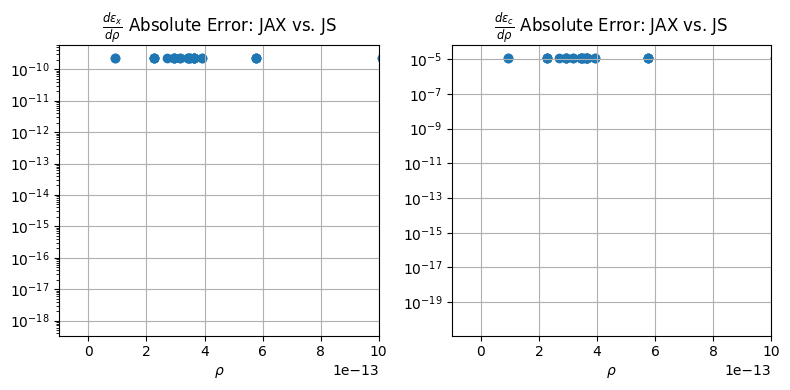

In [304]:
f = plt.figure(figsize=(8, 4))
xa = f.add_subplot(121)
ca = f.add_subplot(122)
axs = [xa, ca]
xa.scatter(rho[0, :], abs(js_dexdd - jax_dexdd))
ca.scatter(rho[0, :], abs(js_decdd - jax_decdd))
for ax in axs:
    ax.set_yscale('log')
    rlim = 0.000000000001
    ax.set_xlim(-rlim/10, rlim)
    ax.grid()
xa.set_xlabel('$\\rho$')
ca.set_xlabel('$\\rho$')
xa.set_title('$\\frac{d\\epsilon_x}{d\\rho}$ Absolute Error: JAX vs. JS')
ca.set_title('$\\frac{d\\epsilon_c}{d\\rho}$ Absolute Error: JAX vs. JS')
plt.tight_layout()

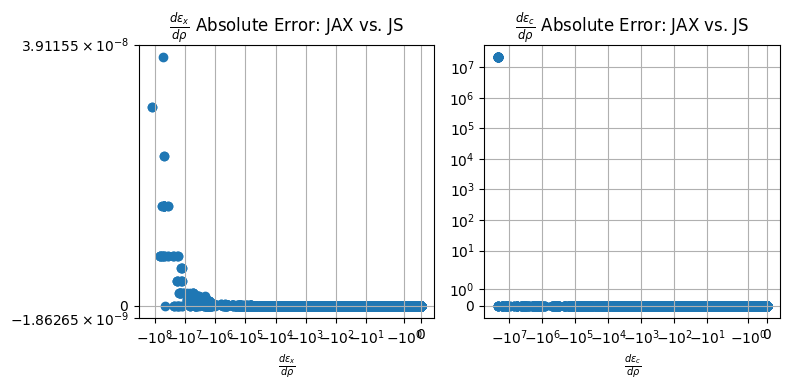

In [235]:
f = plt.figure(figsize=(8, 4))
xa = f.add_subplot(121)
ca = f.add_subplot(122)
axs = [xa, ca]
xa.scatter(js_dexdd, abs(js_dexdd - jax_dexdd))
ca.scatter(js_decdd, abs(js_decdd - jax_decdd))
for ax in axs:
    ax.set_yscale('symlog')
    ax.set_xscale('symlog')
    # ax.set_xlim(-0.1, 2)
    ax.grid()
xa.set_xlabel('$\\frac{d\\epsilon_x}{d\\rho}$')
ca.set_xlabel('$\\frac{d\\epsilon_c}{d\\rho}$')
xa.set_title('$\\frac{d\\epsilon_x}{d\\rho}$ Absolute Error: JAX vs. JS')
ca.set_title('$\\frac{d\\epsilon_c}{d\\rho}$ Absolute Error: JAX vs. JS')
plt.tight_layout()

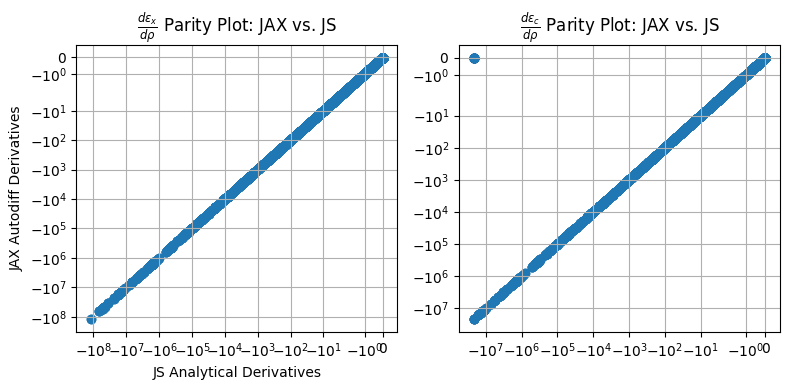

In [177]:
f = plt.figure(figsize=(8, 4))
xa = f.add_subplot(121)
ca = f.add_subplot(122)
axs = [xa, ca]
xa.scatter(js_dexdd, jax_dexdd)
ca.scatter(js_decdd, jax_decdd)
for ax in axs:
    ax.set_yscale('symlog')
    ax.set_xscale('symlog')
    # ax.set_xlim(-0.1, 2)
    ax.grid()

xa.set_xlabel('JS Analytical Derivatives')
xa.set_ylabel('JAX Autodiff Derivatives')
xa.set_title('$\\frac{d\\epsilon_x}{d\\rho}$ Parity Plot: JAX vs. JS')
ca.set_title('$\\frac{d\\epsilon_c}{d\\rho}$ Parity Plot: JAX vs. JS')
plt.tight_layout()

In [307]:
#store as global values for use in function below
GRIDC = pmf.grids.coords
GRIDW = pmf.grids.weights

#A new function using specifically the networks that have the modified LOB wrapping function to avoid nans in gradients
def net_eval_xc_g_lda(xc_code, rho, spin=0, relativity=0, deriv=1, omega=None, verbose=None):
    #flag to determine changing jax arrays to numpy on return
    CONVERT_TO_NUMPY = True

    print(f'eval_xc call rho shape = {rho.shape}')
    frho0 = rho
    frho0 = jnp.maximum(1e-10, frho0) #Prevents division by 0
    print(f'frho0 max = {frho0.max()}')
    print(f'frho0 shape = {frho0.shape}')
    finputs = frho0
    
    def get_exc(inputs):    
        rho0 = inputs
        e_heg_x = jsexchng_exonly(rho0)
        e_heg_c = jscorr_cust(rho0)
    
        Fx = 1
        Fc = 1
        exc = e_heg_x*Fx + e_heg_c*Fc
        return exc

    v_and_g = eqx.filter_value_and_grad(get_exc)
    hess = eqx.filter_hessian(get_exc)
    
    exc, v = jax.vmap(v_and_g)(finputs)
    h = jax.vmap(hess)(finputs)
    print(f'exc shape = {exc.shape}')
    print(f'exc stats: max/min/mean = {exc.max()}, {exc.min()}, {exc.mean()}')
    # print(f'v shape = {v.shape}')
    # print(f'h shape = {h.shape}')
    # print(f'v nans = {jnp.sum(jnp.isnan(v))}')
    # print(f'h nans = {jnp.sum(jnp.isnan(h))}')
    
    #need functional derivatives for the potentials:
    vrho = v
    vgamma = None
    vlapl = None
    vtau = None
    
    #second order derivatives
    # per jax docs, indices [Hf]_{i,j} = d2f/(didj)
    v2rho2 = None
    v2rhosigma = None
    v2sigma2 = None
    v2lapl2 = None
    vtau2 = None
    v2rholapl = None
    v2rhotau = None
    v2lapltau = None
    v2sigmalapl = None
    v2sigmatau = None
    # 2nd order functional derivative
    fxc = (v2rho2, v2rhosigma, v2sigma2, v2lapl2, vtau2, v2rholapl, v2rhotau, v2lapltau, v2sigmalapl, v2sigmatau)
    kxc = None  # 3rd order functional derivative
    vxc = [vrho, vgamma, vlapl, vtau]
    if CONVERT_TO_NUMPY:
        return np.asarray(exc), [np.asarray(i) for i in vxc], [np.asarray(i) for i in fxc], kxc
    else:
        return exc, vxc, fxc, kxc


In [308]:
mol.verbose = 9
mfL = dft.RKS(mol)
mfL.grids.level = 1
mfL.grids.build()
mfL.define_xc_(net_eval_xc_g_lda, 'LDA', hyb=0)
mfL.kernel()
EnetL = mfL.e_tot

atom O rad-grids = 40, ang-grids = [ 50  50  50  50  50  50  50  50  50  50  50  50  86  86  86  86  86 170
 170 170 194 194 194 194 194 194 194 194 194 194 194 170 170 170 170 170
 170 170 170 170]
atom H rad-grids = 30, ang-grids = [ 50  50  50  50  50  50  50  50  86  86  86  86  86 110 110 110 110 110
 110 110 110  86  86  86  86  86  86  86  86  86]
tot_boxes 990, boxes in each direction [7 9 8]
Padding 4 grids
tot grids = 10176


******** <class 'pyscf.dft.rks.RKS'> ********
method = RKS
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /home/awills/Documents/Research/xcquinox/notebooks/tmp_99p_29m
max_memory 4000 MB (current use 1396 MB)
XC library pyscf.dft.libxc version 6.1.0
    S. Lehtola, C. Steigemann, M. J.T. Oliveira, and M. A.L. Marques.,  SoftwareX 

In [309]:
(Epbe, mf.scf_summary), (EnetL, mfL.scf_summary, mfL.converged)

((-76.33345765899357,
  {'e1': -123.16722829254861,
   'coul': 46.92499882266204,
   'exc': -9.279486606853109,
   'nuc': 9.188258417746113}),
 (-63.45604101306847,
  {'e1': -92.80372422790927,
   'coul': 26.70115090384889,
   'exc': -6.541726106754212,
   'nuc': 9.188258417746113},
  False))

In [299]:
#store as global values for use in function below
GRIDC = pmf.grids.coords
GRIDW = pmf.grids.weights

#A new function using specifically the networks that have the modified LOB wrapping function to avoid nans in gradients
def net_eval_xc_g2(xc_code, rho, spin=0, relativity=0, deriv=1, omega=None, verbose=None):
    #flag to determine changing jax arrays to numpy on return
    CONVERT_TO_NUMPY = True

    print(f'eval_xc call rho shape = {rho.shape}')
    frho0, fdx, fdy, fdz = rho[:4]
    fsigma = fdx**2 + fdy**2 + fdz**2
    fgamma = jnp.sqrt(fsigma)
    frho0 = jnp.maximum(1e-10, frho0) #Prevents division by 0
    print(f'frho0 max = {frho0.max()}')
    print(f'frho0 shape = {frho0.shape}')
    finputs = jnp.stack([frho0, fsigma], axis=1)
    
    def get_exc(inputs):    
        rho0 = inputs[0, jnp.newaxis]
        sigma = inputs[1, jnp.newaxis]
        gamma = jnp.sqrt(sigma)
        inp = {}
        inp['rho'] = rho0[0]
        inp['sigma'] = gamma[0]

        # e_heg_c = get_heg_ec(rho0[0], gamma[0])
        # e_heg_c = get_heg_ec(rho0[0])
        # e_heg_x = get_heg_ex(rho0[0])
        # e_heg_x, _ = jsexchng(rho0[0])
        # e_heg_c, _ = jscorr(rho0[0])
        e_heg_x = jsexchng_exonly(rho0)
        e_heg_c = jscorr_cust(rho0)
    
        # print(f'e_heg_c shape = {e_heg_c.shape}, e_heg_x shape = {e_heg_x.shape}')
        # print(f'e_heg_c = {e_heg_c}, e_heg_x = {e_heg_x}')        
        k_F = (3 * jnp.pi**2 * rho0)**(1/3)
        s = gamma/(2*k_F*rho0+1e-10)
        Fx = model_fx3(s)
        # Fx = 1
        sinputs = jnp.array([rho0[0], s[0]])
        Fc = model_fc3(sinputs)
        # Fc = 1
        exc = e_heg_x*Fx + e_heg_c*Fc
        return exc[0]

    v_and_g = eqx.filter_value_and_grad(get_exc)
    hess = eqx.filter_hessian(get_exc)
    
    exc, v = jax.vmap(v_and_g)(finputs)
    h = jax.vmap(hess)(finputs)
    print(f'exc shape = {exc.shape}')
    print(f'exc stats: max/min/mean = {exc.max()}, {exc.min()}, {exc.mean()}')
    # print(f'v shape = {v.shape}')
    # print(f'h shape = {h.shape}')
    # print(f'v nans = {jnp.sum(jnp.isnan(v))}')
    # print(f'h nans = {jnp.sum(jnp.isnan(h))}')
    
    #need functional derivatives for the potentials:
    vrho = v[:, 0]
    vgamma = v[:, 1]
    vlapl = None
    vtau = None
    
    #second order derivatives
    # per jax docs, indices [Hf]_{i,j} = d2f/(didj)
    v2rho2 = h[:, 0, 0]
    v2rhosigma = h[:, 0, 1]
    v2sigma2 = h[:, 1, 1]
    v2lapl2 = None
    vtau2 = None
    v2rholapl = None
    v2rhotau = None
    v2lapltau = None
    v2sigmalapl = None
    v2sigmatau = None
    # 2nd order functional derivative
    fxc = (v2rho2, v2rhosigma, v2sigma2, v2lapl2, vtau2, v2rholapl, v2rhotau, v2lapltau, v2sigmalapl, v2sigmatau)
    kxc = None  # 3rd order functional derivative
    vxc = [vrho, vgamma, vlapl, vtau]
    if CONVERT_TO_NUMPY:
        return np.asarray(exc), [np.asarray(i) for i in vxc], [np.asarray(i) for i in fxc], kxc
    else:
        return exc, vxc, fxc, kxc


In [311]:
mol.verbose = 9
mf6 = dft.RKS(mol)
mf6.grids.level = 1
mf6.grids.build()
mf6.define_xc_(net_eval_xc_g2, 'GGA', hyb=0)
mf6.kernel()
Enet5 = mf5.e_tot

atom O rad-grids = 40, ang-grids = [ 50  50  50  50  50  50  50  50  50  50  50  50  86  86  86  86  86 170
 170 170 194 194 194 194 194 194 194 194 194 194 194 170 170 170 170 170
 170 170 170 170]
atom H rad-grids = 30, ang-grids = [ 50  50  50  50  50  50  50  50  86  86  86  86  86 110 110 110 110 110
 110 110 110  86  86  86  86  86  86  86  86  86]
tot_boxes 990, boxes in each direction [7 9 8]
Padding 4 grids
tot grids = 10176


******** <class 'pyscf.dft.rks.RKS'> ********
method = RKS
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /home/awills/Documents/Research/xcquinox/notebooks/tmpct681pyg
max_memory 4000 MB (current use 1398 MB)
XC library pyscf.dft.libxc version 6.1.0
    S. Lehtola, C. Steigemann, M. J.T. Oliveira, and M. A.L. Marques.,  SoftwareX 

In [301]:
(Epbe, mf.scf_summary), (Enet5, mf6.scf_summary, mf6.converged)

((-76.33345765899357,
  {'e1': -123.16722829254861,
   'coul': 46.92499882266204,
   'exc': -9.279486606853109,
   'nuc': 9.188258417746113}),
 (0,
  {'e1': -91.36238936694039,
   'coul': 25.712918816113486,
   'exc': -6.813384505184602,
   'nuc': 9.188258417746113},
  False))

# look at difference between the density/gradients from one-shot PBE with libxc and with out network; can we call a hybrid functional with mixed PBE/network X/C to see where most error comes from (if not both); Fx=Fc=1 for LDA function, compare to pyscf LDA do we obtain the same results etc;
- unclear if PySCF is working with sigma (norm squared), gamma (norm), which does it assume the derivatives are w.r.t.
- gradient calculation is not done analytically here, but through JAX, which might cause an error. Can see on first step if e-density evaluated with PBE from libxc is the same (or close) as evaluated with our model.
- Gradients returned by libxc should be close to what the model returns as well
- Incorporate gradients into network loss function during training
- Fc=Fx=1 test (with analytical densities but JAX gradients) already fails, so JAX gradients are likely incorrect; compare a JAX-gradient calculation with one using the gradients already coded in JS code

### Development cells below.

Per the `pyscf.dft.libxc.eval_xc` docstring, (relevant parts included):
```
        rho : ndarray
            Shape of ((*,N)) for electron density (and derivatives) if spin = 0;
            Shape of ((*,N),(*,N)) for alpha/beta electron density (and derivatives) if spin > 0;
            where N is number of grids.
            rho (*,N) are ordered as (den,grad_x,grad_y,grad_z,laplacian,tau)
            where grad_x = d/dx den, laplacian = \nabla^2 den, tau = 1/2(\nabla f)^2
            In spin unrestricted case,
            rho is ((den_u,grad_xu,grad_yu,grad_zu,laplacian_u,tau_u)
                    (den_d,grad_xd,grad_yd,grad_zd,laplacian_d,tau_d))

    Kwargs:
        spin : int
            spin polarized if spin > 0
        relativity : int
            No effects.
        verbose : int or object of :class:`Logger`
            No effects.

    Returns:
        ex, vxc, fxc, kxc

        where

        * vxc = (vrho, vsigma, vlapl, vtau) for restricted case

        * vxc for unrestricted case
          | vrho[:,2]   = (u, d)
          | vsigma[:,3] = (uu, ud, dd)
          | vlapl[:,2]  = (u, d)
          | vtau[:,2]   = (u, d)

        * fxc for restricted case:
          (v2rho2, v2rhosigma, v2sigma2, v2lapl2, vtau2, v2rholapl, v2rhotau, v2lapltau, v2sigmalapl, v2sigmatau)

        * fxc for unrestricted case:
          | v2rho2[:,3]     = (u_u, u_d, d_d)
          | v2rhosigma[:,6] = (u_uu, u_ud, u_dd, d_uu, d_ud, d_dd)
          | v2sigma2[:,6]   = (uu_uu, uu_ud, uu_dd, ud_ud, ud_dd, dd_dd)
          | v2lapl2[:,3]
          | v2tau2[:,3]     = (u_u, u_d, d_d)
          | v2rholapl[:,4]
          | v2rhotau[:,4]   = (u_u, u_d, d_u, d_d)
          | v2lapltau[:,4]
          | v2sigmalapl[:,6]
          | v2sigmatau[:,6] = (uu_u, uu_d, ud_u, ud_d, dd_u, dd_d)

```
and per `pyscf.lib.dft.libxc_itrf.c`, 
```
/* Extracted from comments of libxc:gga.c

    sigma_st          = grad rho_s . grad rho_t
    zk                = energy density per unit particle

    vrho_s            = d n*zk / d rho_s
    vsigma_st         = d n*zk / d sigma_st

    v2rho2_st         = d^2 n*zk / d rho_s d rho_t
    v2rhosigma_svx    = d^2 n*zk / d rho_s d sigma_tv
    v2sigma2_stvx     = d^2 n*zk / d sigma_st d sigma_vx

    v3rho3_stv        = d^3 n*zk / d rho_s d rho_t d rho_v
    v3rho2sigma_stvx  = d^3 n*zk / d rho_s d rho_t d sigma_vx
    v3rhosigma2_svxyz = d^3 n*zk / d rho_s d sigma_vx d sigma_yz
    v3sigma3_stvxyz   = d^3 n*zk / d sigma_st d sigma_vx d sigma_yz

 if nspin == 2
    rho(2)          = (u, d)
    sigma(3)        = (uu, ud, dd)

 * vxc(N*5):
    vrho(2)         = (u, d)
    vsigma(3)       = (uu, ud, dd)

 * fxc(N*45):
    v2rho2(3)       = (u_u, u_d, d_d)
    v2rhosigma(6)   = (u_uu, u_ud, u_dd, d_uu, d_ud, d_dd)
    v2sigma2(6)     = (uu_uu, uu_ud, uu_dd, ud_ud, ud_dd, dd_dd)
    v2lapl2(3)
    vtau2(3)
    v2rholapl(4)
    v2rhotau(4)
    v2lapltau(4)
    v2sigmalapl(6)
    v2sigmatau(6)
```

All this to say that the gradients in `libxc` itself are assumed to be with respect to the density, not the total energy. That is, $$vrho = \frac{d\epsilon}{d\rho},$$ and $$vsigma = \frac{\partial \epsilon}{\partial \sigma}, \ \ \sigma = [\nabla\rho_\uparrow\cdot \nabla\rho_\uparrow,\nabla\rho_\uparrow\cdot \nabla\rho_\downarrow,\nabla\rho_\downarrow\cdot \nabla\rho_\downarrow].$$

We are not spin polarizing here, so perhaps the second element should be zero.

In [ ]:
#store as global values for use in function below
GRIDC = mf.grids.coords
GRIDW = mf.grids.weights
def net_eval_xc4(xc_code, rho, spin=0, relativity=0, deriv=1, omega=None, verbose=None):
    rho0, dx, dy, dz = rho[:4]
    gamma = (dx**2 + dy**2 + dz**2)
    rho0 = jnp.maximum(1e-12, rho0) #Prevents division by 0
    heg_rho_array = np.zeros((6, len(rho0)))  # Initialize the rho_array with the correct shape. Only the first element (rho) matters, so the rest are populated with 0. 
    heg_rho_array[0, :] = rho0  # Populate first array value with rho
    e_heg_c = dft.libxc.eval_xc(',LDA_C_PW', heg_rho_array, spin=spin, deriv=deriv)[0]
    e_heg_x = dft.libxc.eval_xc('LDA_X,', heg_rho_array, spin=spin, deriv=deriv)[0]
    inputs = jnp.stack([rho0, gamma], axis=1)

    def get_Exc_exc(inputs):    
        k_F = (3 * jnp.pi**2 * inputs[0, :])**(1/3)
        s = inputs[1, :]/(2*k_F*inputs[0, :])
        Fx = jax.vmap(model_fx2)(s[:, jnp.newaxis])
        Fc = jax.vmap(model_fc2)(inputs)
        # print(f'g shapes: rho={rho.shape}')
        # print(f'g shapes: inputs={inputs.shape}')
        # print(f'g shapes: rho0={rho0.shape}, dx=dy=dz={dx.shape}')
        # print(f'g shapes: gamma={gamma.shape}')
        # print(f'g shapes: e_heg_c={e_heg_c.shape}, e_heg_x={e_heg_x.shape}')
        # print(f'g s.shape = {s.shape}')

        exc = e_heg_x*Fx + e_heg_c*Fc
        Exc = jnp.sum(rho0*exc*GRIDW)
        return Exc, exc
    
    Exc_exc, v = eqx.filter_value_and_grad(get_Exc_exc, has_aux=True)(rho)
    Exc, exc = Exc_exc
    # print(f'shapes: rho0={rho0.shape}, dx=dy=dz={dx.shape}')
    # print(f'shapes: gamma={gamma.shape}')
    # print(f'shapes: e_heg_c={e_heg_c.shape}, e_heg_x={e_heg_x.shape}')
    # print(f's.shape = {s.shape}')
    # print(f'Exc = {Exc}')
    # print(f'exc.shape = {exc.shape}')
    print(f'v.shape = {v.shape}')
    #need functional derivatives for the potentials:
    vrho = v[0, :]    
    # print(f'vrho.shape = {vrho.shape}')
    vgamma = v[1:, :].T
    vlapl = None
    vtau = None
    #unclear, but try
    vxc = (vrho, vgamma, vlapl, vtau)
    return exc, vxc, None, None


In [ ]:
mf5 = dft.RKS(mol)
mf5.define_xc_(net_eval_xc4, 'GGA', hyb=0)
mf5.kernel()

# Important: Equinox update from v0.11.3 to 0.11.4 now includes the filter function for Hessian calculation.

So the functional derivatives are clearly necessary for an accurate calculation, bringing the error from ~100 eV to ~1 eV. But the Coulomb and this `e1` energy are still off by a bit.

Let's see if the second-order derivatives help.

Hessian evaluation seems computationally impossible due to memory usage with this set-up. Problematic. **User beware with the below code, it will quickly saturate any RAM on a non-HPC machine. Untested on HPC clusters.**

In [ ]:
mf6 = dft.RKS(mol)
mf6.grids.level = 1
mf6.grids.build()

In [ ]:
#store as global values for use in function below
GRIDC = mf4.grids.coords
GRIDW = mf4.grids.weights
def net_eval_xc_h(xc_code, rho, spin=0, relativity=0, deriv=1, omega=None, verbose=None):
    rho0, dx, dy, dz = rho[:4]
    gamma = (dx**2 + dy**2 + dz**2)
    rho0 = jnp.maximum(1e-12, rho0) #Prevents division by 0
    heg_rho_array = np.zeros((6, len(rho0)))  # Initialize the rho_array with the correct shape. Only the first element (rho) matters, so the rest are populated with 0. 
    heg_rho_array[0, :] = rho0  # Populate first array value with rho
    e_heg_c = dft.libxc.eval_xc(',LDA_C_PW', heg_rho_array, spin=spin, deriv=deriv)[0]
    e_heg_x = dft.libxc.eval_xc('LDA_X,', heg_rho_array, spin=spin, deriv=deriv)[0]
    # inputs = jnp.stack([rho0, gamma], axis=1)

    def get_Exc_exc(rho):    
        rho0, dx, dy, dz = rho[:4]
        gamma = (dx**2 + dy**2 + dz**2)
        rho0 = jnp.maximum(1e-12, rho0) #Prevents division by 0
        inputs = jnp.stack([rho0, gamma], axis=1)
        k_F = (3 * jnp.pi**2 * rho0)**(1/3)
        s = gamma/(2*k_F*rho0)
        Fx = jax.vmap(model_fx2)(inputs[1, jnp.newaxis])
        Fc = jax.vmap(model_fx2)(inputs)
        # print(f'g shapes: rho={rho.shape}')
        # print(f'g shapes: inputs={inputs.shape}')
        # print(f'g shapes: rho0={rho0.shape}, dx=dy=dz={dx.shape}')
        # print(f'g shapes: gamma={gamma.shape}')
        # print(f'g shapes: e_heg_c={e_heg_c.shape}, e_heg_x={e_heg_x.shape}')
        # print(f'g s.shape = {s.shape}')

        exc = e_heg_x*Fx + e_heg_c*Fc
        Exc = jnp.sum(rho0*exc*GRIDW)
        return Exc, exc
    #for hessian generation maybe?
    @eqx.filter_jit
    def get_Exc(rho):    
        rho0, dx, dy, dz = rho[:4]
        gamma = (dx**2 + dy**2 + dz**2)
        rho0 = jnp.maximum(1e-12, rho0) #Prevents division by 0
        inputs = jnp.stack([rho0, gamma], axis=1)
        k_F = (3 * jnp.pi**2 * rho0)**(1/3)
        s = gamma/(2*k_F*rho0)
        Fx = jax.vmap(model_fx2)(inputs[1, jnp.newaxis])
        Fc = jax.vmap(model_fx2)(inputs)
        # print(f'h shapes: rho={rho.shape}')
        # print(f'h shapes: inputs={inputs.shape}')
        # print(f'h shapes: rho0={rho0.shape}, dx=dy=dz={dx.shape}')
        # print(f'h shapes: gamma={gamma.shape}')
        # print(f'h shapes: e_heg_c={e_heg_c.shape}, e_heg_x={e_heg_x.shape}')
        # print(f'h s.shape = {s.shape}')

        exc = e_heg_x*Fx + e_heg_c*Fc
        Exc = jnp.sum(rho0*exc*GRIDW)
        return Exc

    
    Exc_exc, v = eqx.filter_value_and_grad(get_Exc_exc, has_aux=True)(rho)
    Exc, exc = Exc_exc
    print('getting hessian')
    h = eqx.filter_hessian(get_Exc)(rho)
    print(f'shapes: hessian = {h.shape}')
    # print(f'shapes: rho0={rho0.shape}, dx=dy=dz={dx.shape}')
    # print(f'shapes: gamma={gamma.shape}')
    # print(f'shapes: e_heg_c={e_heg_c.shape}, e_heg_x={e_heg_x.shape}')
    # print(f's.shape = {s.shape}')
    # print(f'Exc = {Exc}')
    # print(f'exc.shape = {exc.shape}')
    # print(f'v.shape = {v.shape}')
    #need functional derivatives for the potentials:
    vrho = v[0, :]    
    # print(f'vrho.shape = {vrho.shape}')
    vgamma = v[1:, :].T
    vlapl = None
    vtau = None
    #unclear, but try
    vxc = (vrho, vgamma, vlapl, vtau)
    return exc, vxc, None, None


In [ ]:
mf6.define_xc_(net_eval_xc_h, 'GGA', hyb=0)

In [ ]:
# mf4.kernel()